##  Methodology
The Food and Agriculture Organization of the United Nations (FAO) conducted a household
survey in Nigeria through the Data in Emergencies Monitoring (DIEM-Monitoring) System to
monitor agricultural livelihoods and food security. This sixth-round survey was conducted
through face-to-face interviews from 21 January to 5 February 2024, reaching
3441 households.

Data collection took place at the beginning of the lean season across five states: Adamawa,
Borno, Katsina, Yobe and Zamfara. Data were collected at the level of local government areas
(administrative level 2) in Zamfara and at state level (administrative level 1) in Adamawa, Borno,
Katsina and Yobe. 

**_Data were weighted using population counts_**

## **Import Libraries and Packages**

In [6]:
# Import Libraries

import os
import sys


# Path needs to be added manually to read from another folder
path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "../utils"))
)
if not (path2add in sys.path):
    sys.path.append(path2add)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, StrMethodFormatter
from matplotlib import rc
import seaborn as sns
import geopandas as gpd

from scipy.stats import (chi2_contingency, kruskal, ttest_ind)

# import utility functions
from eda import (
    fies_by_socio_demo, #fies
    plot_fies_levels_by_vars, # plot
    calculate_weighted_percentage,
    compute_groupby,
    data_type_converter,
    plot_group_by_percentage,
    plot_grouped_data,
    # Crop difficulties
    percentage_crp_prod_dif,
    plot_diff_variables,
    all_top_crp_diff_by_state
)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)




In [7]:
# Load the dataset into the DataFrame
df = pd.read_csv("../../data/DIEM_NG/diem_round_4_ng.csv")
df.shape

(1418, 238)

## Analyzing the data

In [8]:
# Display the first few rows
df.head()

,country,state,local_govt_area,hh_agricactivity,hh_gender,hh_education,hh_size,hh_age,resp_islsproducer,resp_iscropproducer,resp_isfishproducer,weight_final,hh_wealth_toilet,income_main,income_main_amount,income_sec_amount,income_main_comp,fcg,income_sec,income_third,tot_income,shock_noshock,shock_sicknessordeathofhh,shock_lostemplorwork,shock_otherintrahhshock,shock_higherfoodprices,shock_higherfuelprices,shock_mvtrestrict,shock_othereconomicshock,shock_pestoutbreak,shock_plantdisease,shock_animaldisease,shock_napasture,shock_othercropandlivests,shock_coldtemporhail,shock_flood,shock_hurricane,shock_drought,shock_earthquake,shock_landslides,shock_firenatural,shock_othernathazard,shock_violenceinsecconf,shock_theftofprodassets,shock_firemanmade,shock_othermanmadehazard,shock_dk,shock_ref,crp_landsize_ha,crp_main,crp_seed_ownprod,crp_seed_market,crp_seed_company,crp_seed_ngo,crp_seed_organized_community,crp_seed_gov,crp_seed_relatives_friends,crp_seed_other,crp_seed_dk,crp_seed_ref,crp_area_change,crp_harv_change,crp_harv_lastyr_kg,crp_proddif,crp_proddif_plant_disease,crp_proddif_pest_outbreak,crp_proddif_animal_grazing,crp_proddif_access_plot,crp_proddif_access_fertilize,crp_proddif_seed_quality,crp_proddif_seed_quantity,crp_proddif_access_pesticide,crp_proddif_access_labour,crp_proddif_access_machinery,crp_proddif_access_fuel,crp_proddif_soil_erosion,crp_proddif_lack_irrigation,crp_proddif_excess_water,crp_proddif_access_credit,crp_proddif_other,crp_proddif_dk,crp_proddif_ref,crp_storage,crp_salesmain,crp_salesdif,crp_saledif_marketing_cost,crp_saledif_damage_losses,crp_saledif_low_demand,crp_saledif_pay_delay,crp_saledif_low_price,crp_saledif_processing,crp_saledif_competition,crp_saledif_other,crp_saledif_dk,crp_saledif_ref,crp_salesprice,ls_main,ls_num_lastyr,ls_num_now,ls_num_diff,ls_num_increased,ls_num_decreased,ls_num_no_change,ls_num_inc_less_sales,ls_num_inc_more_birth,ls_num_inc_more_acquired,ls_num_inc_received_free,ls_num_dec_poor_health,ls_num_dec_death,ls_num_dec_sales_good_price,ls_num_dec_sales_distress,ls_num_dec_escape_stolen,ls_num_dec_consumed,ls_num_inc_dec_other,ls_num_inc_dec_dk,ls_num_inc_dec_ref,ls_feed_open_pasture,ls_feed_common_pasture,ls_feed_self_produced,ls_feed_purchased,ls_feed_free_dist,ls_feed_other,ls_feed_dk,ls_feed_ref,ls_proddif,ls_proddif_feed_purchase,ls_proddif_access_pasture,ls_proddif_access_water,ls_proddif_vet_serv,ls_proddif_vet_input,ls_proddif_diseases,ls_proddif_theft,ls_proddif_access_market,ls_proddif_access_credit,ls_proddif_access_labour,ls_proddif_other,ls_proddif_dk,ls_proddif_ref,ls_salesmain,ls_salesdif,ls_salesdif_marketing_cost,ls_salesdif_damage_losses,ls_salesdif_low_demand,ls_salesdif_pay_delay,ls_salesdif_low_price,ls_salesdif_slaughterhouse,ls_salesdif_processing,ls_salesdif_competition,ls_salesdif_other,ls_salesdif_dk,ls_salesdif_ref,ls_salesprice,fish_proddif,fish_salesdif,need,need_food,need_cash,need_vouchers_fair,need_crop_inputs,need_crop_infrastructure,need_crop_knowledge,need_ls_feed,need_ls_vet_service,need_ls_infrastructure,need_ls_knowledge,need_fish_inputs,need_fish_infrastructure,need_fish_knowledge,need_env_infra_rehab,need_cold_storage,need_marketing_supp,need_other,need_dk,need_ref,need_received_food,need_received_cash,need_received_vouchers_fair,need_received_crop_assist,need_received_ls_assist,need_received_fish_assist,need_received_rehabilitation,need_received_sales_support,need_received_other,need_received_none,need_received_dk,need_received_ref,fies_worried,fies_healthy,fies_fewfoods,fies_skipped,fies_ateless,fies_ranout,fies_hungry,fies_whlday,p_mod,p_sev,cs_hh_assets,cs_spent_savings,cs_borrowed_money,cs_sold_prod_assets,cs_no_school,cs_reduced_health_exp,cs_harv_immature_crops,cs_sold_house,cs_begged,cs_illegal,cs_sold_last_female,rcsi_less_preferred_foods,rcsi_borrowed_food,rcsi_reduce_number_meals,rcsi_limit_portions,rcsi_restrict_adult_consumpt,rcsi_score,rcsi_class,hdds_cereals,hdds_rootstubers,hdds_vegetables,hdds_fruits,hdds_meat,h

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Columns: 238 entries, country to income_main_cat
dtypes: float64(213), object(25)
memory usage: 2.6+ MB


### Convert object columns to categorical

In [10]:
# create a dictionary of columns and data type mappinng
conversion_dict = {k: "category" for k in df.select_dtypes("object").columns}

# Convert our dataframe and check the datatypes
df = df.astype(conversion_dict)
# data.info(verbose=True, show_counts=True

We can do even more. Except for the `hh_size`,` weight_final` and `crp_landsize_ha` which are numerical, the rest are categorical.

In [11]:
numerical_cols = ["hh_size", "weight_final", "crp_landsize_ha",
                  "income_main_amount", "income_sec_amount","income_third_amount","tot_income",
                  "ls_lastyr", "ls_num_now", "ls_num_diff", 
                  "fiesrawscore", "p_mod", "p_sev"]

float_to_cat_conversion = {k :"category" for k in df.select_dtypes("float64")\
                           .columns if k not in numerical_cols}
df = df.astype(float_to_cat_conversion)

Already we can see that the memory usage of the dataframe has been reduced from 5+ mb to 767 kb.


### Clean up the columns that ends with `dk` and `ref`.
The dataset contain columns for "don't know" and "refused". For example `crp_proddif_dk`.We want to drop those columns. They are not required for our analysis

In [12]:
# Drop columns that ends with "dk" and "ref"
suff_list = ["_ref", "_dk"]
dk_ref_cols = [col for col in df.columns if col.endswith(tuple(suff_list))]
df = df.drop(columns=dk_ref_cols, axis=1)
# df.info(verbose=True)

### Check for Duplication

In [13]:
df.duplicated().sum()

0

There is no single duplicated record in the data set.

### Missing Value Calculation

In [14]:
df.isna().sum()

country                            0
state                              0
local_govt_area                    0
hh_agricactivity                   0
hh_gender                          0
hh_education                       0
hh_size                            0
hh_age                             0
resp_islsproducer                  0
resp_iscropproducer                0
resp_isfishproducer                0
weight_final                       0
hh_wealth_toilet                  99
income_main                        0
income_main_amount                 1
income_sec_amount                947
income_main_comp                   0
fcg                                0
income_sec                         0
income_third                       0
tot_income                        12
shock_noshock                      0
shock_sicknessordeathofhh          0
shock_lostemplorwork               0
shock_otherintrahhshock            0
shock_higherfoodprices             0
shock_higherfuelprices             0
s

There are instances of missing values in the dataset. Because I am yet to decide what the variables of interest are, I will defer handling it for later in the analysis.

### Let's clean up some columns
For instance, `crp_main` and `crp_salesmain` has values code as 1100-77700 categories. 
The codebook for the dataset provided the appropiate mapping of the variables in our data set

In [15]:
# Main crops
# Define the dictionary
crop_dict = {
    1100: "Rice",
    1200: "Wheat",
    1300: "Millet",
    1400: "Sorghum",
    1500: "Maize",
    1990: "Other Cereal",
    2100: "Cassava",
    2200: "Potatoe",
    2300: "Sweet Potatoes",
    2400: "Yams",
    2990: "Other tubers",
    3100: "Beans",
    3400: "Soybeans",
    4100: "Cabbage",
    4200: "Lettuce",
    4300: "Spinach-Amaranth",
    4500: "Potatoe leaves",
    4700: "Sorrel Hibiscus / Rosselle",
    4990: "Other leafy vegetables",
    5100: "Tomatoes",
    5600: "Okra",
    5700: "Bell pepper",
    5800: "Onions",
    7180: "Melon [Cantaloupe]",
    7300: "Papaya",
    7800: "Water Melon",
    8200: "Groundnut/peanut",
    8500: "Sesame",
    8600: "Bambara nut",
    9400: "Sugarcane",
    9990: "Other food cash crop",
    10100: "Cotton",
    777000: "No crop production",
    10990: "Other non-food cash crop"
}

df["crp_main"] = df.crp_main.cat.rename_categories(crop_dict)
df["crp_salesmain"] = df.crp_salesmain.cat.rename_categories(crop_dict)



In [16]:
# Define main livestock sold
ls_dict = {1:"Cattle",
           2: "Goat",
           3: "Sheep",
           4: "Swine",
           5: "Equine (Donkey)",
           6: "Small Animals", 
           7: "Poulty", 
           8: "Camel",
           9: "Eggs",
           10: "Milk or diary product",
           11: "Skin or wool"
          }

df["ls_salesmain"] = df["ls_salesmain"].cat.rename_categories(ls_dict)

In [17]:
# Income, cultivated area harvest area, and price change
compare_dict = {1 : "A lot more",
                2: "More",
                3: "Same",
                4: "Less",
                5: "A lot less"}

# Column to rename/recode categories
compare_cols = ["income_main_comp", "crp_area_change", "crp_harv_change",
                 "crp_salesprice", "ls_salesprice"]

for col in compare_cols:
    # rename categories
    df[col] = df[col].cat.rename_categories(compare_dict)

Let's collapse the categories from five to two. That is "Married" and "Single"

### Reordering categories
The order of the following variables matters:
`["income_main_comp", "crp_area_change",
"crp_harv_change", 
 "crp_salesprice",
 "ls_salesprice]` 
 
 These are ordinal variables with clear ordering or rank.

In [18]:
# Set the new order
new_order = ["A lot more", "More", "Same", "Less", "A lot less"]

# Loop through the columns
for col in compare_cols:
    # reorder the values of each column
    df[col] = df[col].cat.reorder_categories(new_order)

In [19]:
# df.info(verbose=True)

### Composition of state present in the dataset

In [20]:
# Unweighted
df["state"].value_counts()

state
Borno      291
Zamfara    287
Adamawa    283
Katsina    282
Yobe       275
Name: count, dtype: int64

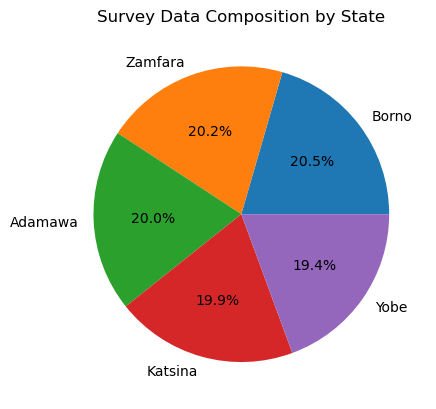

In [21]:
# Plot a pie chart to show the composition of the data by state

# Get pie chart labels
labels = df["state"].value_counts().index.to_numpy()

# Get the pie chart values
values = df["state"].value_counts().values

# Create a pie chart of the number of people surveyed in each state
plt.pie(values, labels=labels, autopct="%1.1f%%")
plt.title("Survey Data Composition by State")
plt.show()



**Observation:**

* The data was collected from relatively the same sample (N) across all state. This is a balance sampled data



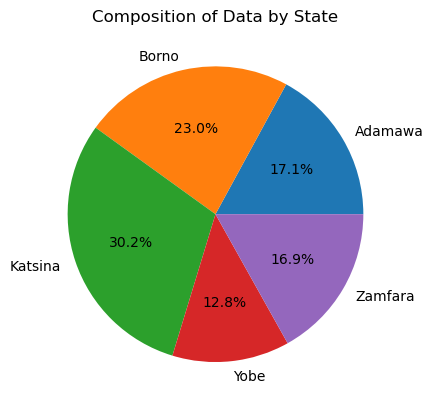

In [22]:
# Weighted Composition of the data by state
# Group data by state and calculate sum of weight
state_composition = df.groupby("state", observed=True)["weight_final"].sum()

# Create a pie chart

plt.pie(state_composition, labels=state_composition.index, autopct="%1.1f%%")
plt.title("Composition of Data by State")
plt.show()

**Observation:**
Upon the apply the `weight_final` variable on the dataset to capture the population:

* The state with the highest number fo surveys is **Katsina** (30.2%).
* The state with the lowest number of surveys is Yobe with 12.8% of the respondents.

**Before performing EDA, lets separate Numerical and categorical variables for easy analysis**

In [23]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [24]:
print(df.shape)

(1418, 218)


## 2.0 EDA
Given the large of variables in the dataset, the following categories will used to select the appropiate variables/columns for our analysis

1. Prevalence of food insecurity (FIES)
2. Demographic
3. Income and Shock
4. Crop production and difficulty
5. Livestock production and difficulty

## 2.1 Univariate and Bivariate Analysis

Analyzing/visualizing the dataset by taking one variable at a time. Univariate analysis will be done for both Categorical and Numerical variables.

Categorical variables will be visualized using a Count plot, Bar Chart, Pie Plot, etc.

Numerical Variables can be visualized using Histogram, Box Plot, Density Plot, etc.


## **FIES**

We already performed the [statistical validation ](notebooks/1_rasch_model.ipynb) needed to ensure that the collected data is appropiate to measure comparable food insecurity.



**Severe** (`FI_sev`): is the proportion of the population experiencing severe levels of food insecurity.

**Moderate or severe** (`FI_mod_sev`): is the SUM of the proportion of the population experiencing
moderate or severe levels of food insecurity, combined. 

_The **raw score** is the number of affirmative responses, 0 to 8. Raw score is ordinal (probabilistically) with respect to the latent trait of food insecurity. As such, it can be used to classify households within a country as to food insecurity status. (Such classification may not represent equal levels of severity between countries, however.) Raw score is NOT an interval measure, so it should **not be used to calculate a mean or in linear regression models**_

**Prevalence of food insecurity**

In [25]:
fies_cols = [col for col in df.columns if col.startswith("fies")]
fies_cols


['fies_worried',
 'fies_healthy',
 'fies_fewfoods',
 'fies_skipped',
 'fies_ateless',
 'fies_ranout',
 'fies_hungry',
 'fies_whlday']

In [26]:
# df[fies_cols[:-1]]
# Compute the weighted number of affirmative responses for each column
weighted_counts = (df[fies_cols[:-1]].astype(float).multiply(df['weight_final'], axis=0)).sum()

# Compute the sum of weights
sum_weights = df['weight_final'].sum()

# Compute the percentage of affirmative responses for each column
weighted_percentages = (weighted_counts / sum_weights) * 100

# Combine the results into a DataFrame
results = pd.DataFrame({
    'weighted_n_affirmative': weighted_counts,
    'weighted_percent_affirmative': weighted_percentages
})

results

,weighted_n_affirmative,weighted_percent_affirmative
fies_worried,661.048580,43.543462
fies_healthy,596.218339,39.273075
fies_fewfoods,689.323688,45.405952
fies_skipped,499.557125,32.905973
fies_ateless,737.392107,48.572233
fies_ranout,119.305596,7.858694
fies_hungry,120.516936,7.938486


In [27]:
# Compute the number of affirmative responses for each column
affirmative_counts = (df[fies_cols[:-1]] == 1.0).sum()

# Compute the percentage of affirmative responses for each column
total_rows = len(df[fies_cols[:-1]])
affirmative_percentages = (affirmative_counts / total_rows) * 100

# Combine the results into a DataFrame
results = pd.DataFrame({
    'n_affirmative': affirmative_counts,
    'percent_affirmative': affirmative_percentages
}).sort_values("percent_affirmative", ascending=False)

results

,n_affirmative,percent_affirmative
fies_ateless,672,47.390691
fies_fewfoods,632,44.569817
fies_worried,589,41.537377
fies_healthy,537,37.870240
fies_skipped,454,32.016925
fies_ranout,115,8.110014
fies_hungry,113,7.968970


* When looking at the distribution of affirmative answers to each FIES question above the item `ATELESS` was reported most often in our sample , followed by the item `fies_fewfoods` and `fies_worried`. Not eating for a whole day `fies_hungry`, was chosen the least

**Composition of `fiesrawscore`**

In [28]:
def compute_fiesrawscore(df, like="fies_"):
    
    fies_df = (df.filter(like=like).astype("float")
               .assign(fiesrawscore = lambda df_:df_.sum(axis=1))
              )
    # Replace the columns
    df_copy = df.copy()
    df_copy[fies_df.columns] = fies_df
    # Drop NaN
    df_copy.dropna(subset=fies_df.columns, inplace=True)
    return df_copy
df = compute_fiesrawscore(df)

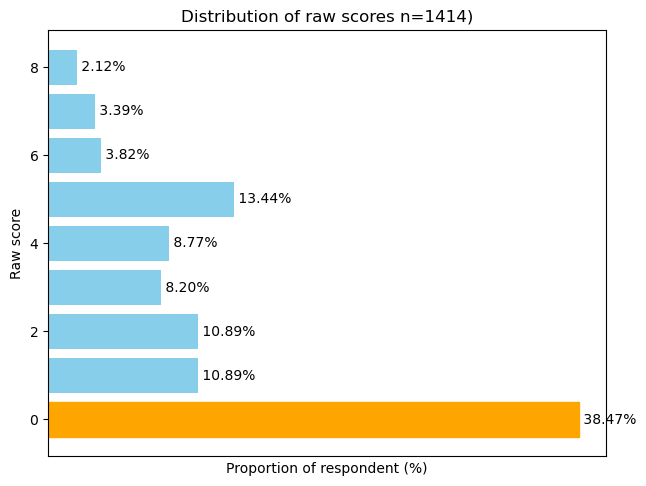

In [29]:
percent = (df["fiesrawscore"].value_counts(normalize=True) * 100).sort_index()

# plt.figure(figsize=(7,4))
ax = plt.barh(percent.index, percent, color='skyblue')

# Annotating the bars with count values
for i, v in enumerate(percent):
    plt.text(v, i, f' {percent.values[i]:.2f}%', va='center')

# Highlighting the bar with raw score value of 0
raw_score_0_index = percent.index.get_loc(0)
ax[raw_score_0_index].set_color('orange')  

# Adding more space around the plot
plt.tight_layout()
plt.title(f"Distribution of raw scores n={len(df)})")
plt.xlabel("Proportion of respondent (%)")
plt.ylabel("Raw score")
# plt.xlim((0, 25))
# plt.grid(True, axis="x")
plt.xticks([], []);

* Valid: 1414, Minimum: 0 Maximum: 8
* The figure show the distribution of the raw scores in our data:
> * 38.5% respondents had a raw score of 0. They did not experience any of the assessed RFI. In the framework of the FIES they are considered **Food Secure**.

**Impact**


Suggested thresholds according to [FAO](https://www.fao.org/3/bp091e/bp091e.pdf):
* Raw score 1 or greater versus raw score 0 (any indication of food insecurity)
* Raw score 4 or greater versus raw score 0-3 (On average, this corresponds
  approximately to moderately-or-severely food insecure versus secure-or-only-mildly insecure.)
* Raw score 7 or 8 versus raw score 0-6 (On average, this corresponds approximately to severely food insecure versus all others.)


#### **Relationship between rawscore and probability of food insecurity.**

To achieve precise comparability of prevalence rates of food insecurity, we used the respondent parameter produced by the **Rasch model** which contains the probability of **moderate-or-severe** (`FI_mod_sev`) or **severe** (`FI_sev`) food insecurity for a respondent with each of the nine possible raw scores (0-8).

We assigned household probabilistically to classes of food insecurity severity in order to calculate rates of food insecurity at different levels of severity.

## **Household Demographic Characteristics**
The household demographic characteristics will include the following variables hh gender, state, education, income: source of income, agricultural activities, household size, hh age, production activities; livestocks only, crop only, ls and crop, land size

#### Household Head Age `hh_age`

The `hh_age` is a categorical variables.

In [30]:
df["hh_age"].value_counts().to_frame().reset_index()

,hh_age,count
0,41 to 65,917
1,18 to 40,426
2,Over 65,71


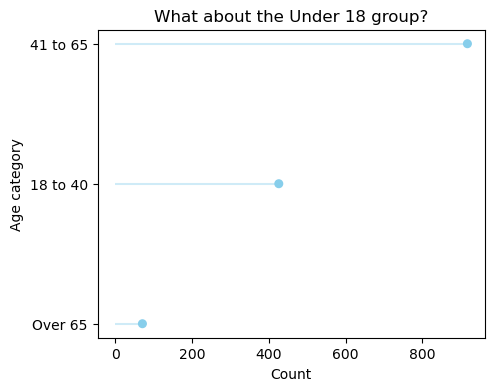

In [31]:
#  Composition hh_age distribution by state
# Reorder it based on values:
age_dist = df["hh_age"].value_counts().to_frame().reset_index()
ordered_df = age_dist.sort_values(by='count')
my_range=range(1,len(age_dist.index)+1)
 
# Create a color if the group is "B"
my_color=np.where(ordered_df ['hh_age']=='Under 18', 'orange', 'skyblue')
my_size=np.where(ordered_df ['hh_age']=='Under 18', 100, 30)
 
# The horizontal plot is made using the hline() function
plt.figure(figsize=(5,4))
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['count'], color=my_color, alpha=0.4)
plt.scatter(ordered_df['count'], my_range, color=my_color, s=my_size, alpha=1)
 
# Add title and axis names
plt.yticks(my_range, ordered_df['hh_age'])
plt.title("What about the Under 18 group?")
plt.xlabel('Count')
plt.ylabel('Age category')

# show the graph
plt.show()

#### **Household Land Size in ha  `crp_landsize_ha`**

In [32]:
# Descriptive statistic
df["crp_landsize_ha"].describe()

count      1414.000000
mean        254.339749
std        8006.537465
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max      300000.000000
Name: crp_landsize_ha, dtype: float64

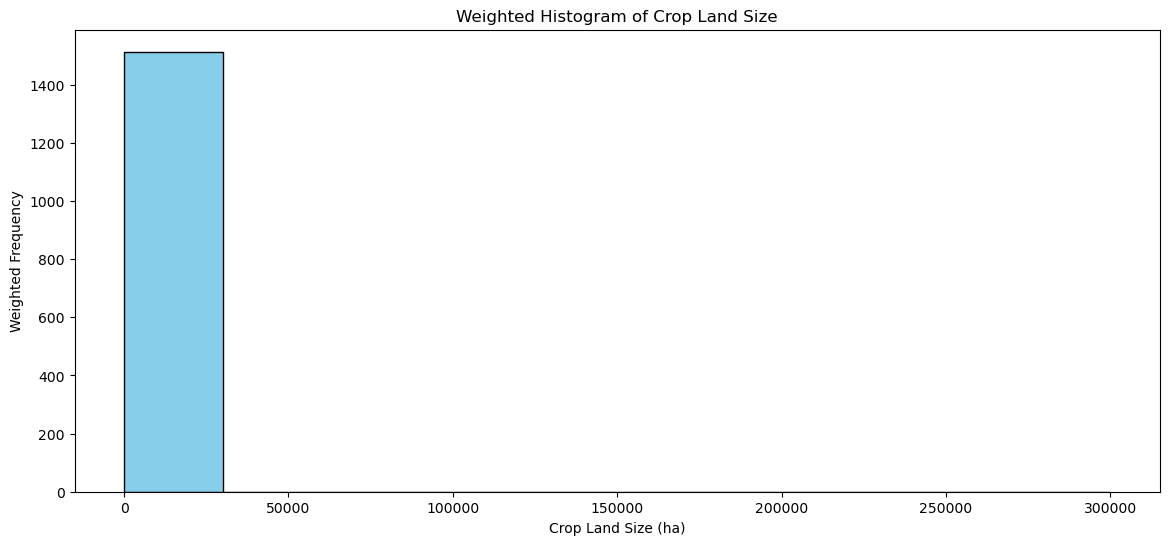

In [33]:
# Weighted mean
weighted_mean = np.average(df['crp_landsize_ha'], weights=df['weight_final'])
# Weighted variance and standard deviation
weighted_variance = np.average((df['crp_landsize_ha'] - weighted_mean)**2, weights=df['weight_final'])
weighted_std = np.sqrt(weighted_variance)


# Plotting weighted histogram
plt.figure(figsize=(14, 6))

plt.hist(df['crp_landsize_ha'], bins=10, weights=df['weight_final'], edgecolor='black', color='skyblue')
plt.xlabel('Crop Land Size (ha)')
plt.ylabel('Weighted Frequency')
plt.title('Weighted Histogram of Crop Land Size')
plt.show()

#### **Household size  `hh_size`**

In [34]:
df["hh_size"].describe()

count    1414.000000
mean        7.188119
std         2.331051
min         1.000000
25%         6.000000
50%         7.000000
75%         9.000000
max        13.000000
Name: hh_size, dtype: float64

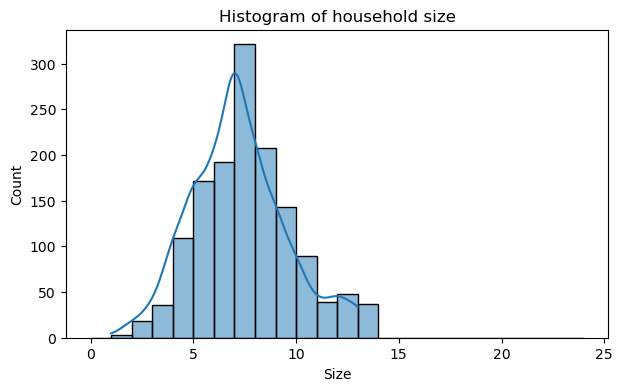

In [35]:
# Create a histogram of hh_size
plt.figure(figsize=(7,4))
sns.histplot(data=df, x="hh_size", bins=range(0, 25, 1), kde=True)
# ax.set_xticks(range(0, 25, 1))
# ax.set_xticklabels(range(0,25,1))
plt.title("Histogram of household size")
plt.xlabel("Size");

<Axes: xlabel='hh_size'>

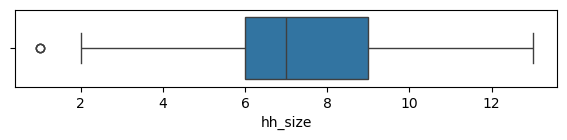

In [36]:
plt.figure(figsize=(7,1))
sns.boxplot(data=df, x="hh_size")

* Household size is normally distributed
* Household size ranges from 1-14 members

#### **Household Head Education  `hh_education`**

In [37]:
df["hh_education"].value_counts()

hh_education
Secondary Education    608
Higher Education       421
Primary Education      223
Religious Education    116
No Education            46
Name: count, dtype: int64

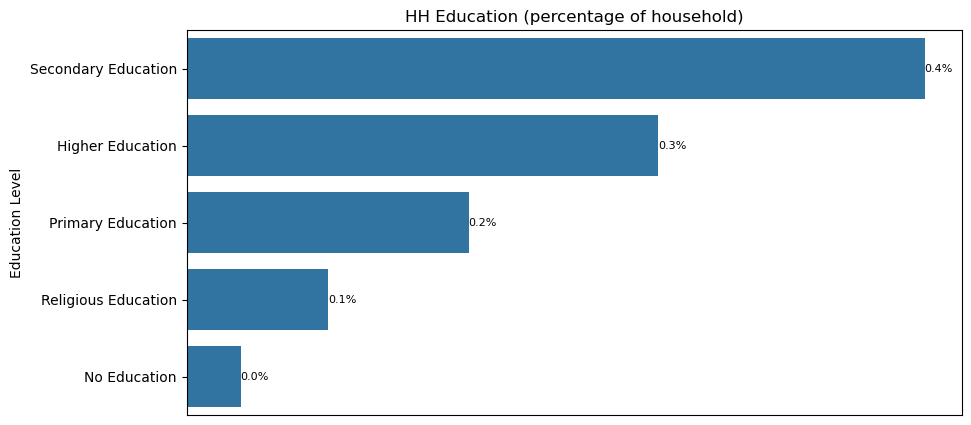

In [38]:
# Weighted count of the distribution of education in the dataset
hh_education_grp_percent = calculate_weighted_percentage(df, "hh_education", "weight_final")

plot_group_by_percentage(hh_education_grp_percent, 
                         "hh_education", 
                         ylabel="Education Level",
                         title="HH Education (percentage of household)")

In [39]:
# Distribution of level of education by state

In [40]:
pd.crosstab(df['state'], df['hh_education'], margins = False) 

hh_education,Higher Education,No Education,Primary Education,Religious Education,Secondary Education
state,,,,,
Adamawa,89,10,44,15,125
Borno,95,12,46,24,113
Katsina,76,7,47,23,129
Yobe,68,11,38,32,124
Zamfara,93,6,48,22,117


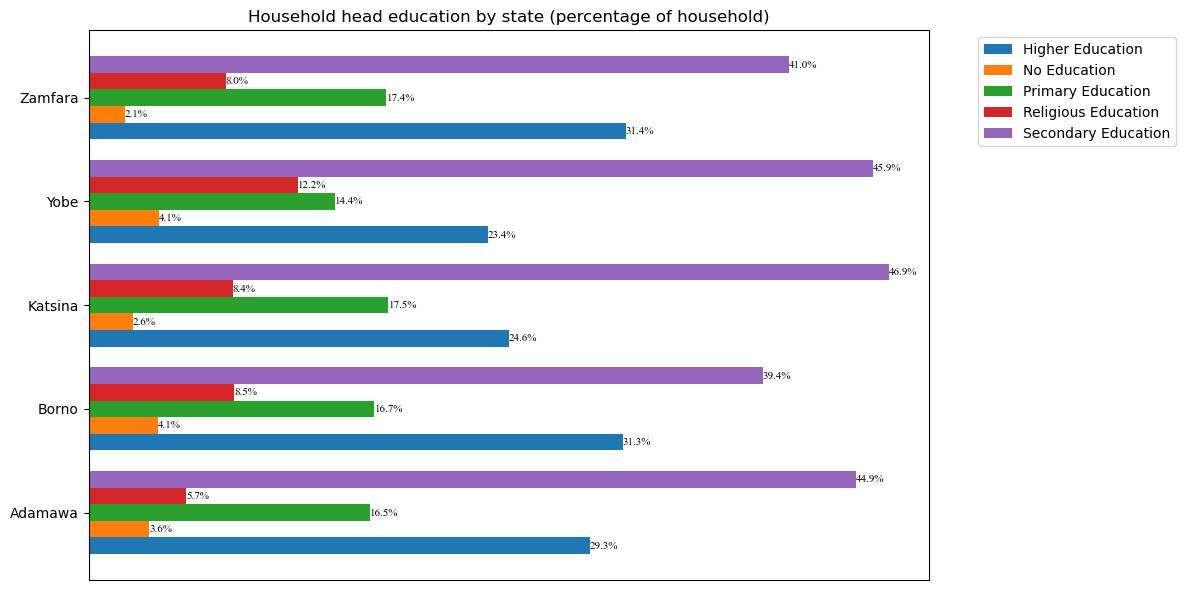

In [41]:
percet_edu_by_state = compute_groupby(df, "state", "hh_education")

plot_grouped_data(percet_edu_by_state,
                  title="Household head education by state (percentage of household)", legend_title="")

In [42]:
# Education and FI_mod_sev and FI_sev

In [43]:
# Perform Kruskal-Wallis test
# Categorical independent variable `hh_education` and ordinal dependent variable.
h_statistic, p_value = kruskal(
    df[df["hh_education"] == "No Education"]["fiesrawscore"],
    df[df["hh_education"] == "Primary Education"]["fiesrawscore"],
    df[df["hh_education"] == "Secondary Education"]["fiesrawscore"],
    df[df["hh_education"] == "Religious Education"]["fiesrawscore"],
    df[df["hh_education"] == "Higher Education"]["fiesrawscore"],
)

# Output the results
print("Kruskal-Wallis test results:")
print("H-statistic:", h_statistic)
print("P-value:", p_value)


Kruskal-Wallis test results:
H-statistic: 134.46948006705458
P-value: 4.308528325986956e-28


**Observation**

* 

#### **Agricultural Activities `hh_agricactivity`**

In [44]:
df["hh_agricactivity"].value_counts(normalize=True) * 100

hh_agricactivity
crop production                  44.554455
livetock production              25.247525
crop and livestock production    19.801980
No                               10.396040
Name: proportion, dtype: float64

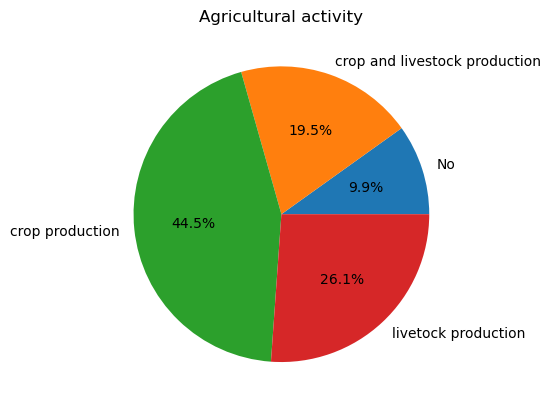

In [45]:
result = df.groupby("hh_agricactivity", observed=True)["weight_final"].sum()

plt.pie(result, labels=result.index, autopct="%1.1f%%")
plt.title("Agricultural activity")
plt.show()



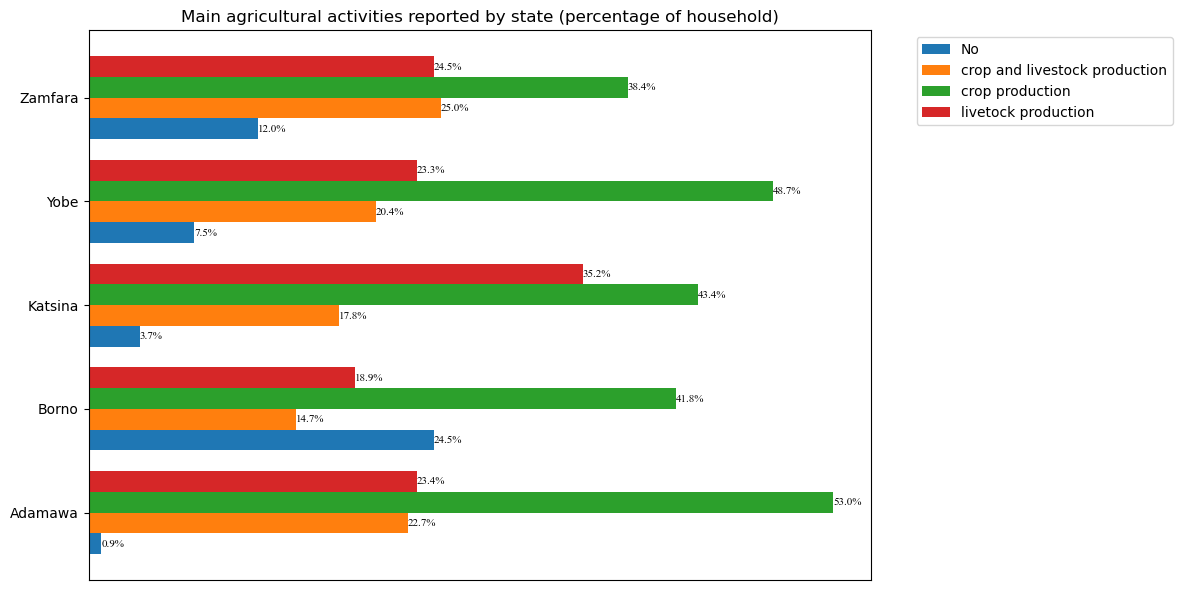

In [46]:
percet_hh_agricactivity = compute_groupby(df, "state", "hh_agricactivity")

plot_grouped_data(percet_hh_agricactivity,
                  title="Main agricultural activities reported by state (percentage of household)", 
                  legend_title="")

**Observation**
* In terms of agricultural activities, 19.5% the households participated in both crop and livestock production. While 44.5% and 26% participated in crop and livestock only production respectively.
* All respondents acros the five states report more crop production compared to other agricultural activities

## **Demography Income and Shock**

In [47]:
df[["income_main_cat"]].value_counts().head()

income_main_cat                   
Agricultural employment               1180
Non Agricultural employment            228
Income from charity and remittance       6
Name: count, dtype: int64

**Create a new column  `income_more_than_one`**

This represents a variable for houshold with more than one income.

In [48]:
# Has more than one income

# Extract values of the three income source columns
income_values = df[["income_main", "income_sec", "income_third"]].values

# check if any of the values is not 19
income_not_19 = income_values != 19.0

# Check if at least two income sources are not equal to 19
more_than_one_income = np.sum(income_not_19, axis=1) > 1

# # Map boolean values to 'Yes' or 'No'
df["income_more_than_one"] = np.where(more_than_one_income, "Yes", "No")


In [49]:
# check the outcome
df[["income_main", "income_sec", "income_third", "income_more_than_one"]].head()

,income_main,income_sec,income_third,income_more_than_one
0,3.0,19.0,19.0,No
1,4.0,3.0,2.0,Yes
2,4.0,1.0,19.0,Yes
3,1.0,4.0,19.0,Yes
4,4.0,19.0,19.0,No


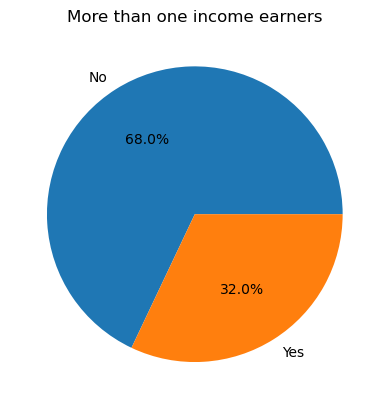

In [50]:
result = df.groupby("income_more_than_one")["weight_final"].sum()
plt.pie(result, labels=result.index, autopct="%1.1f%%")
plt.title("More than one income earners")
plt.show()

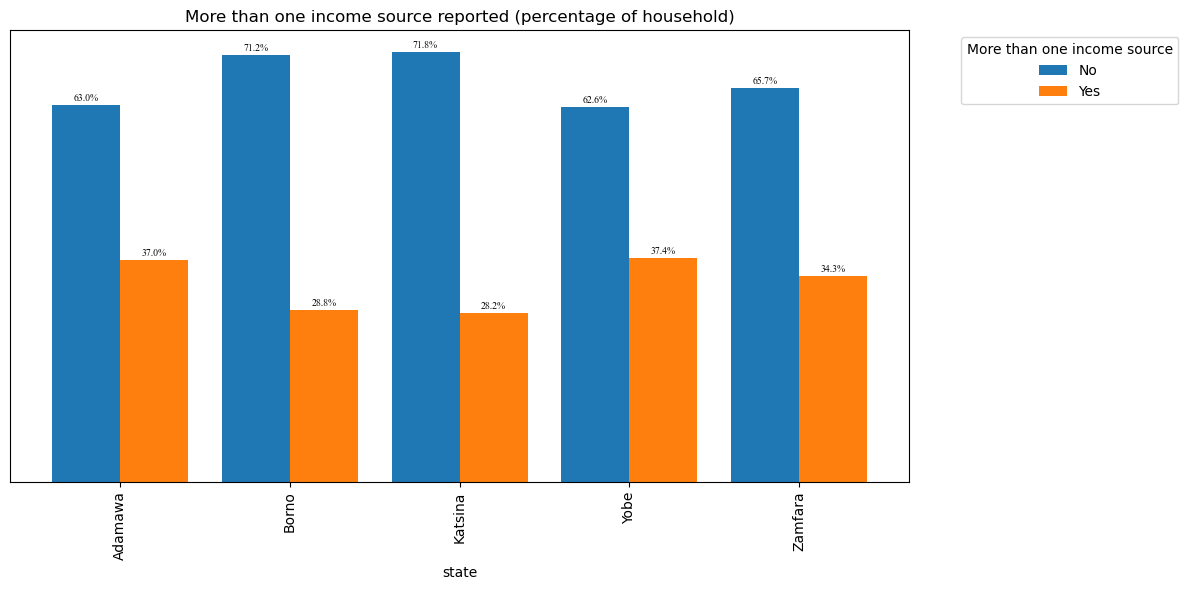

In [51]:
# Compute the pivot
more_than_one_inc = compute_groupby(df, "state", "income_more_than_one")

# Plot the bar plot of household with more than one income by state
plot_grouped_data(more_than_one_inc, kind="bar",
                  title="More than one income source reported (percentage of household)",
                 xlabel="State", legend_title='More than one income source')


**Observation**
* All the states reported to have more households with only one one source of income. With Borno at 77% being the highest followed closely by Katsina state.



#### **Univariate and Bivariate analysis of Income change `income_main_comp`**

In [52]:

df.income_main_comp.value_counts()


income_main_comp
More          511
Less          428
Same          320
A lot less     83
A lot more     72
Name: count, dtype: int64

**Lets handle the level. Create a new variable `income_comp_clean`** by colapsing the values from 4 to 2.

In [53]:
# Defined a dictionary to map old income comp to new ones
new_comp = {
    "Less": "Decrease",
    "A lot less": "Decrease",
    "More": "Increase",
    "A lot more": "Increase",
}

# Replace the old categories with new ones
df["income_comp_clean"] = df["income_main_comp"].replace(new_comp)


/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_19464/2040700517.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["income_comp_clean"] = df["income_main_comp"].replace(new_comp)


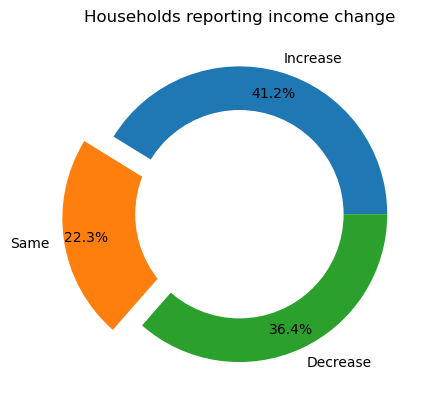

In [54]:
# Household reporting income increase

# Group by 'income_comp_clean' and sum the weights
group_weight_sum = df.groupby("income_comp_clean", observed=True)["weight_final"].sum().reset_index()

# Calculate the total weight
total_weight = group_weight_sum["weight_final"].sum()

# Calculate the proportion of each category
group_weight_sum["proportion"] = (group_weight_sum["weight_final"] / total_weight)

names = group_weight_sum["income_comp_clean"].unique()
size = group_weight_sum.proportion.values

# size = df.groupby("income_comp_clean")["weight_final"].sum()


# explosion
explode = (0, 0.2, 0)

# Create a circle at the center of the plot
plt.pie(size,labels=names,autopct='%1.1f%%', pctdistance=0.85, explode=explode)

my_circle = plt.Circle( (0,0), 0.7, color='white')

# Custom wedges
# plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
# Adding Title of chart
plt.title("Households reporting income change")
plt.show()

In [55]:
## Income compare by state
# What is the distribution of the income compare by state

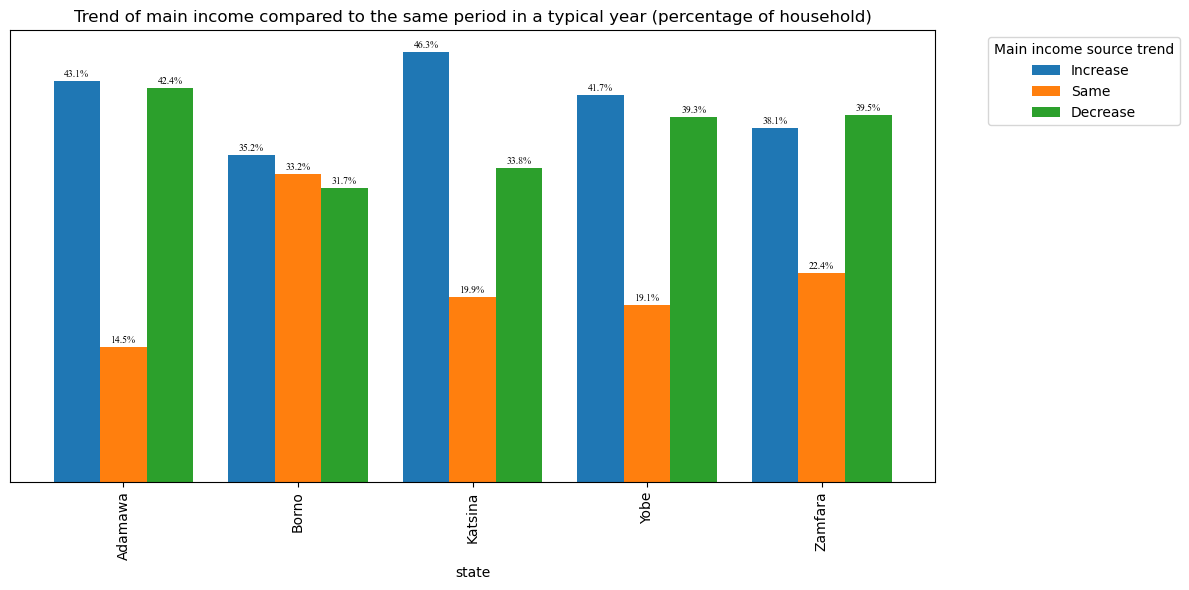

In [56]:
# Compute the pivot
hh_income_comp = compute_groupby(df, "state", "income_comp_clean")

# Plot the bar plot of household with more than one income by state
plot_grouped_data(
    hh_income_comp,
    kind="bar",
    title="Trend of main income compared to the same period in a typical year (percentage of household)",
    legend_title="Main income source trend",
)

In [57]:
df.shape

(1414, 221)

**Observation**

!TODO




**What could be responsible for this increase/decrease?**
* More than one income
* Shock
* crop area
* harvest area

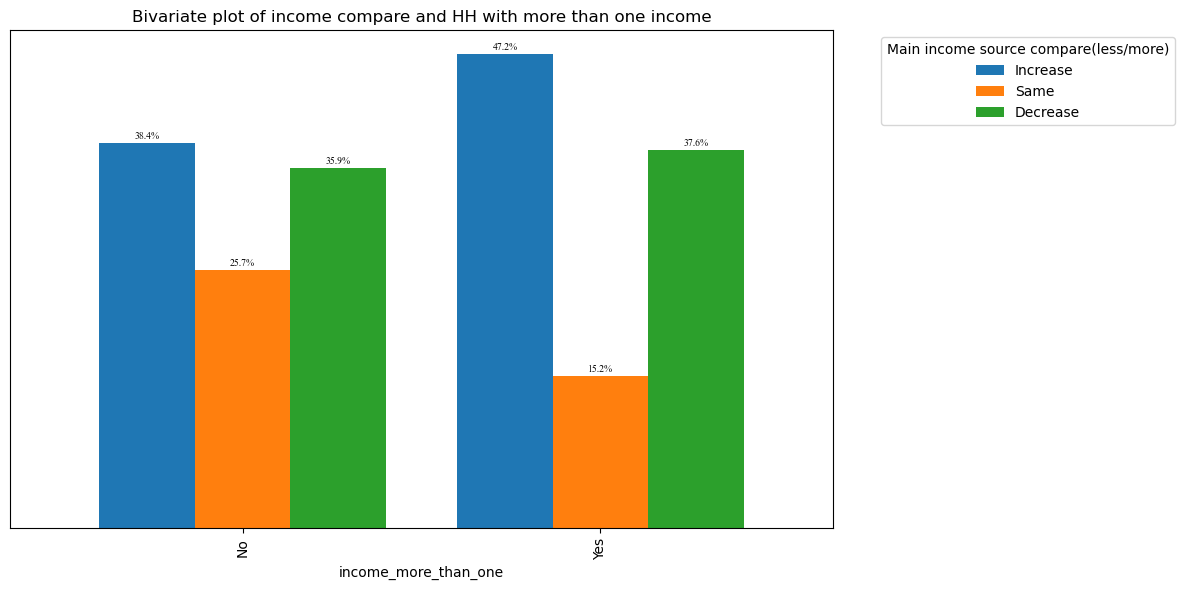

In [58]:
income_comp_wt_more_than_one_income = compute_groupby(df,  
                                                     "income_more_than_one",
                                                     "income_comp_clean",
                                                    )

plot_grouped_data(income_comp_wt_more_than_one_income, kind="bar",
                  title="Bivariate plot of income compare and HH with more than one income", 
                 legend_title="Main income source compare(less/more)")

In [59]:
df.shape

(1414, 221)

* Respondents who report more than one income source, experience increased income (38.7%) compared to respondents with one income source (26.4%). 

#### Source of Main Income `income_main`

* What percentage of household recorded no source of income?

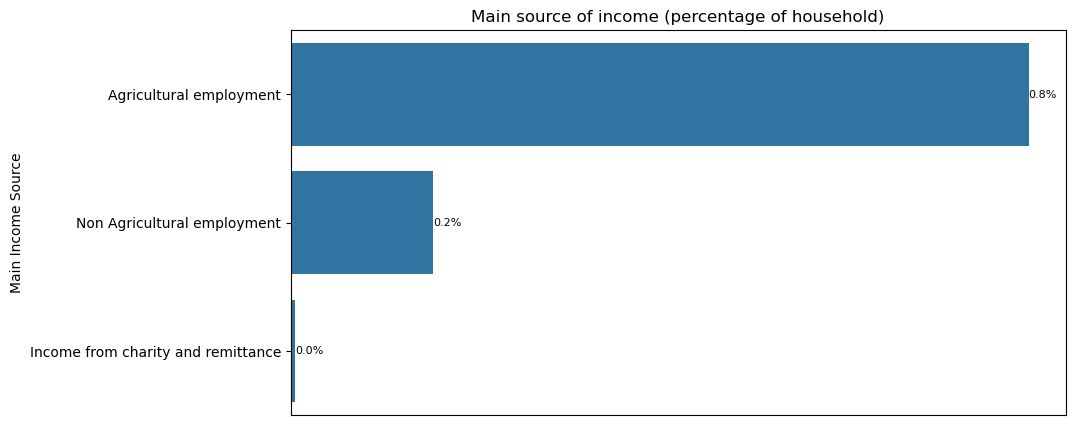

,income_main_cat,weighted_sum,percentage
0,Agricultural employment,1263.222939,0.834
1,Income from charity and remittance,7.159851,0.005
2,Non Agricultural employment,243.971967,0.161


In [60]:
#
income_main_cat_grp_count = calculate_weighted_percentage(df, "income_main_cat", "weight_final")

plot_group_by_percentage(
    income_main_cat_grp_count,
    "income_main_cat",
    ylabel="Main Income Source",
    title="Main source of income (percentage of household)",
)

income_main_cat_grp_count


**Observation**
* 83 percent of the surveyed households reported 'Production and sale of agricultural produce' as their `income_main`

**How does `income_main`(primary source of income) relates with income `income_main_comp`?**

In [61]:
hh_income_comp

income_comp_clean,Increase,Same,Decrease
state,,,
Adamawa,43.098096,14.522394,42.379510
Borno,35.168067,33.154776,31.677157
Katsina,46.278762,19.921684,33.799553
Yobe,41.662546,19.066847,39.270607
Zamfara,38.062202,22.432996,39.504802


In [62]:
df.shape

(1414, 221)

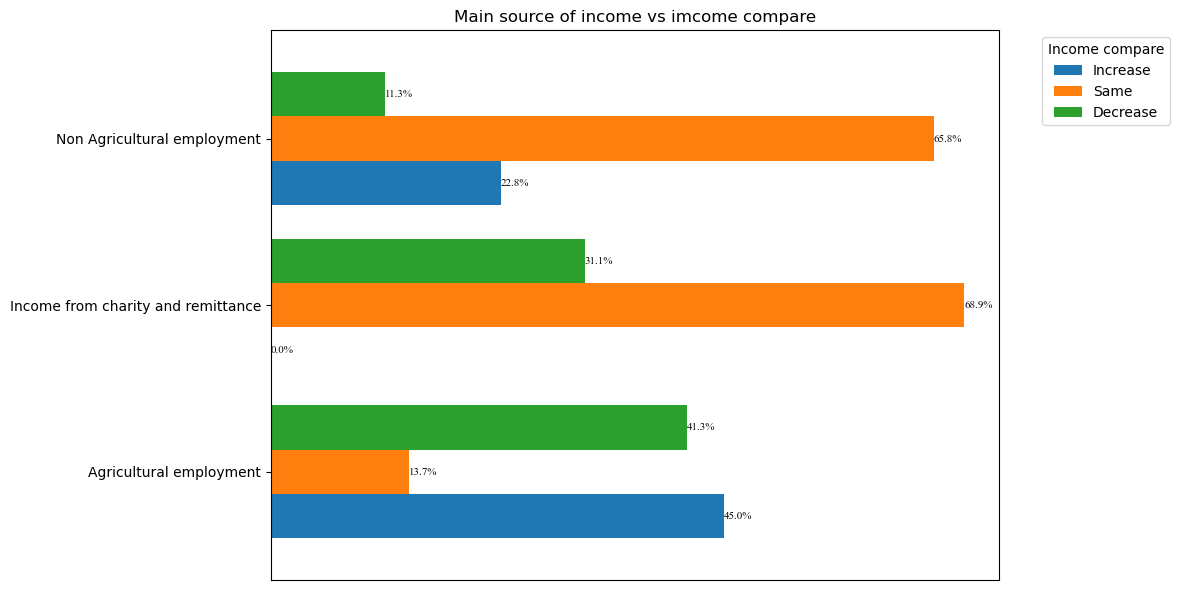

In [63]:
# Income compare with Income source
hh_income_comp = compute_groupby(df, "income_main_cat", "income_comp_clean")

# Plot the bar plot of household with more than one income by state
plot_grouped_data(
    hh_income_comp,
    kind="barh",
    title="Main source of income vs imcome compare",
    legend_title="Income compare",
)

**Observation**

##### TODO
* Households that encountered the most notable decline in primary income, excluding those with no employment, primarily derived their income from the collection and sale of bush and wood, accounting for 73% of cases.
* Household engaged in production and sale of agricultural produce report more increase in income compared to other source of income at (40.7 percent).

Is the relationship significant? Lets test it

* $H_o$ : Main income compare and main income source are independent
* $H_a$ : Main income compare and main income source are not independent


In [64]:
# Chi-square Test of Independence

# contigency
income_comp_crosstab = pd.crosstab(df["income_comp_clean"], 
                                   df["income_main_cat"], 
                                   margins=True, margins_name="subtotal")

chi, p, dof, expected = chi2_contingency(income_comp_crosstab)
print(p)

3.716614215448075e-61


* Yes, because the p-value is so small, we reject the null hypothesis, therefor, there is a relationship between main source of income and if a household report increase or decrease in their income.

### **Demography Shock**

In [65]:
#  Select columns from the DataFrame that start with "shock".
shocks_col = [col for col in df.columns if col.startswith("shock")]

# Create a DataFrame containing only columns related to specific shocks, removing non-relevant ones.
df_shock = df[shocks_col].drop(columns=["shock_noshock"])

df_shock.columns

Index(['shock_sicknessordeathofhh', 'shock_lostemplorwork',
       'shock_otherintrahhshock', 'shock_higherfoodprices',
       'shock_higherfuelprices', 'shock_mvtrestrict',
       'shock_othereconomicshock', 'shock_pestoutbreak', 'shock_plantdisease',
       'shock_animaldisease', 'shock_napasture', 'shock_othercropandlivests',
       'shock_coldtemporhail', 'shock_flood', 'shock_hurricane',
       'shock_drought', 'shock_earthquake', 'shock_landslides',
       'shock_firenatural', 'shock_othernathazard', 'shock_violenceinsecconf',
       'shock_theftofprodassets', 'shock_firemanmade',
       'shock_othermanmadehazard'],
      dtype='object')

There are 24 different shocks presented in the data

#### **Main Reported Shock**

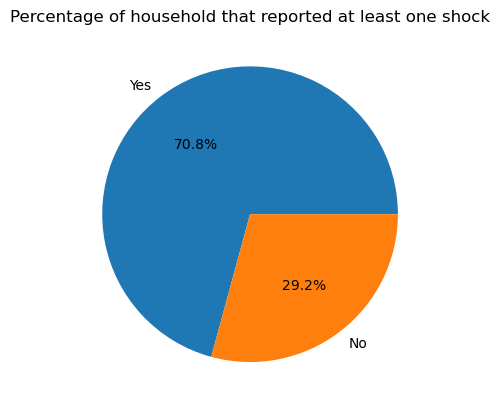

In [66]:
#? What percent of the surveyed household reported facing at least one shock
# Calculate the total weight
total_weight = df["weight_final"].sum()

# calculate total weighted sum of the shocks
weight_sum_shock = df.groupby("shock_noshock", observed=True)["weight_final"].sum()

# Calculate the weight percentage
weight_shock = (weight_sum_shock / total_weight) * 100

# Create a pie chart

# Rename the index
weight_shock.index  = ["Yes", "No"]

plt.pie(weight_shock, labels=weight_shock.index, autopct="%1.1f%%")
plt.title("Percentage of household that reported at least one shock")
plt.show()

In [67]:
# Main reported shock
def percentage_main_shocks(df, n, wt="weight_final"):

    # Subset the shock variables
    shocks = df.loc[:, "shock_sicknessordeathofhh":"shock_othermanmadehazard"].astype(int)

    # compute the weighted count of each shock
    weighted_shocks = shocks.multiply(df[wt], axis=0)

    # Sum the weighted counts for each shock
    weighted_shocks_sum = weighted_shocks.sum()

    # Calculate the total weight
    total_weight = df[wt].sum()

    # Calculate the percentage for each shock
    percentage_shocks = ((weighted_shocks_sum / total_weight) * 100).sort_values(ascending=False)

    main_shocks = pd.DataFrame(
        percentage_shocks.head(n), columns=["Percent"]
    ).reset_index()
    main_shocks.columns = ["Shock Type", "Percent"]
    return main_shocks


# Top ten main shocks
top_shocks = percentage_main_shocks(df, 7)

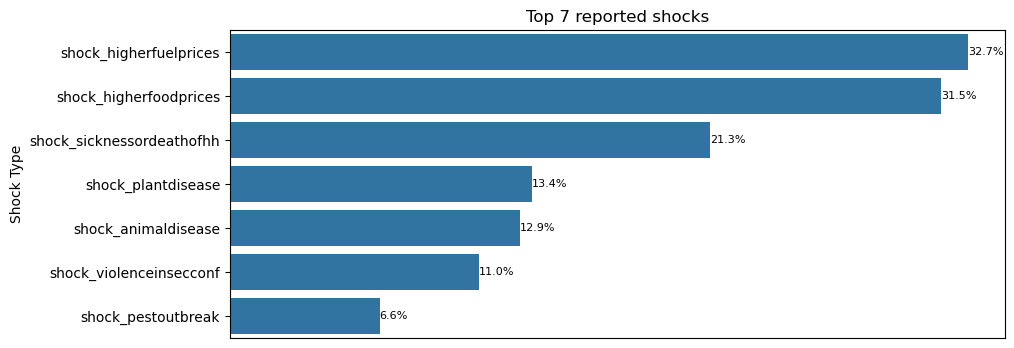

In [68]:
# Plot the shocks
plt.figure(figsize=(10, 4))
ax = sns.barplot(top_shocks, x="Percent", y="Shock Type",)

# Add percentage labels to the bars
ax.bar_label(ax.containers[0], fontsize=8, fmt="%1.1f%%") 

# Remove x-axis ticks and lables 
ax.xaxis.set_ticks([])
ax.set_xlabel("")
ax.set_title("Top 7 reported shocks")

plt.show();

**Observations: TO BE UPDATED**
* Ninety-nine percent of the surveyed households reported having faced at least one shock in the three months preceding the interview.
* The main reported shocks were unusually high food prices (81 percent). Followed by unusually high fuel or transport prices (72 percent)
* Other economic shocks, such as inflation, have affected 43 percent of the households, followed by other intra-household shocks (25 percent).
*  Other reported shocks were sickness, accident or death of a household member (19 percent), violence and insecurity (18 percent), and plant disease (12 percent).


**Main Shocks by State**

In [69]:
# Subset the shock columns
top_shocks_col = top_shocks["Shock Type"].to_list()
all_shock_cols = list(df_shock.columns)

# Calculate the weighted count for each shock
weighted_shocks = df[all_shock_cols].astype(int).multiply(df["weight_final"], axis=0)

# Add the weighted shocks to the dataframe
weighted_df = df[["state", "weight_final"]].join(weighted_shocks)

# Group by state and sum the weighted counts and weights
grouped = weighted_df.groupby("state", observed=True).sum()

# Calculate the percentage for each shock
for col in all_shock_cols:
    grouped[col] = (grouped[col] / grouped["weight_final"]) * 100

# Keep only the percentage columns
percentage_columns = [col for col in all_shock_cols]
all_shocks_by_state = grouped[percentage_columns]

# Display the result
top_shocks_by_state = all_shocks_by_state[top_shocks_col]



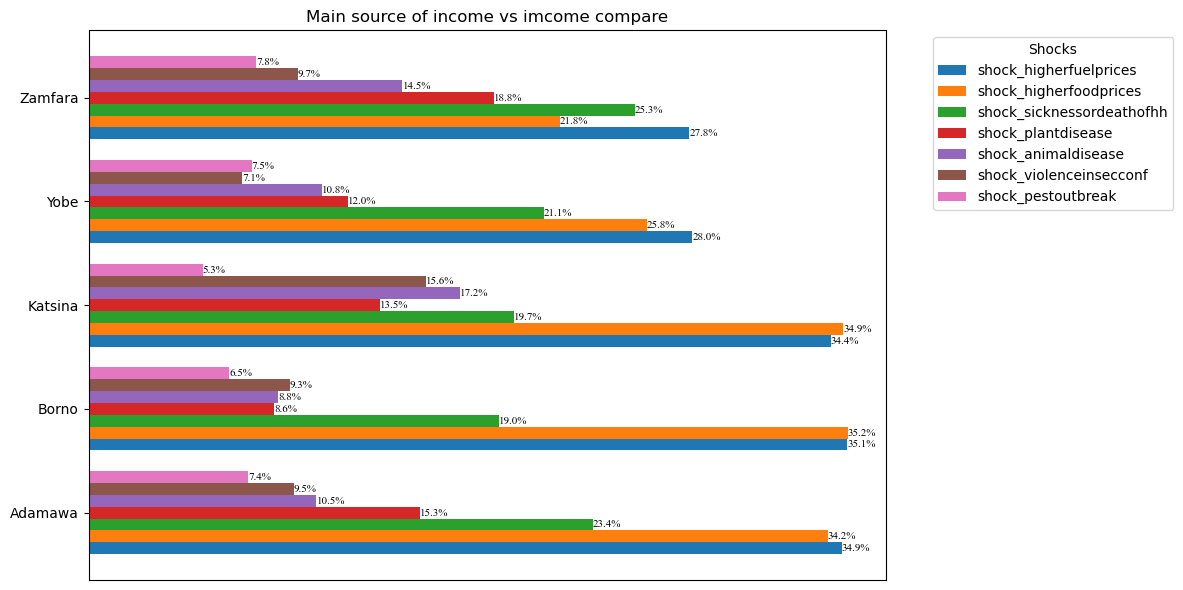

In [70]:
# Plot the top shocks experienced by state
plot_grouped_data(
    top_shocks_by_state,
    kind="barh",
    title="Main source of income vs imcome compare",
    legend_title="Shocks",
)

**TO BE UPDATED**

* In Adamawa, in particular, 99.4 percent of the surveyed households experienced both higher food prices and higher fuel prices shocks.
* After Adamawa, Yobe experienced the most shock from higher food prices (98 percent) and high fuel price at 77 percent.
* Zamfara reported the highest shock from violence and conflicts (53.2 percent) followed by Borno state (29.0 percent). Yobe experienced the least shock from violence and conflicts as less than 1 percent.
* Other economic shock such as inflation was more prevalent among the surveyed respondent in Borno (70 percent) followed by Katsina (46.2 percent)



**Climate and Agricultural Shocks by state**

In [71]:
# List of columns representing shocks related to agriculture and climate
ag_shock_cols = [
    "shock_drought",
    "shock_flood",
    "shock_plantdisease",
    "shock_pestoutbreak",
    "shock_animaldisease",
]

top_climate_ag_shock = all_shocks_by_state[ag_shock_cols]
top_climate_ag_shock


,shock_drought,shock_flood,shock_plantdisease,shock_pestoutbreak,shock_animaldisease
state,,,,,
Adamawa,6.352938,0.652821,15.334647,7.396931,10.544875
Borno,4.189665,1.047416,8.606754,6.511921,8.767834
Katsina,6.698759,0.390471,13.479189,5.288996,17.198642
Yobe,5.458720,0.663149,11.997808,7.543742,10.801535
Zamfara,6.303656,0.628880,18.762941,7.763953,14.522200


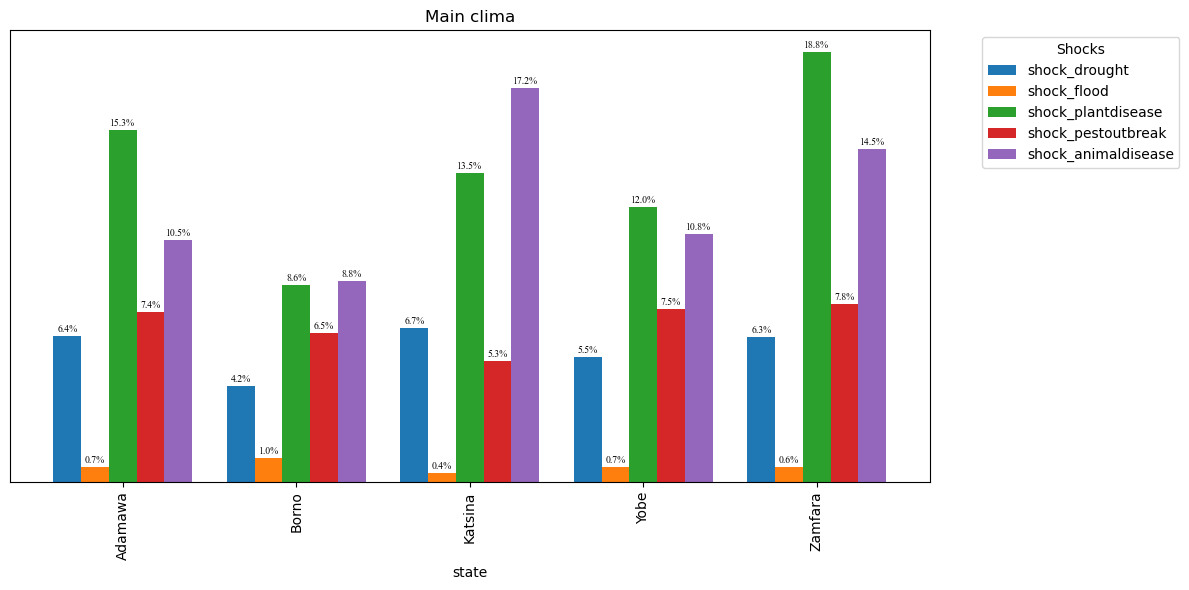

In [72]:
# Plot the top shocks experienced by state
plot_grouped_data(
    top_climate_ag_shock,
    kind="bar",
    title="Main clima",
    legend_title="Shocks",
)

* Shock from drought is highest in Borno (37 percent) followed by Yobe (14 percent). No shock from drought was reported in Adamawa.
* Though no shock from drought was reported in Adamawa, it reports the highest percentage of pest ourtbreak (28.9 percent) and Plant disease (25.0 percent)
* Animal disease was mostly reported by respondent in Adawama state

**Shocks by Agricultural Activities `hh_agricactivity`**

12 most frequent shocks are associated with the agricultural activity.

In [73]:
# 7 most frequent shocks columns

top_shocks = percentage_main_shocks(df, 12)

top_shocks_col = top_shocks["Shock Type"].to_list()

# Calculate the weighted count for each shock
weighted_shocks = df[all_shock_cols].astype(int).multiply(df["weight_final"], axis=0)

# Add the weighted shocks to the dataframe
weighted_df = df[["hh_agricactivity", "weight_final"]].join(weighted_shocks)

# Group by state and sum the weighted counts and weights
grouped = weighted_df.groupby("hh_agricactivity", observed=True).sum()

# Calculate the percentage for each shock
for col in all_shock_cols:
    grouped[col] = (grouped[col] / grouped["weight_final"]) * 100

# Keep only the percentage columns
percentage_columns = [col for col in all_shock_cols]
all_shocks_by_ag_activities = grouped[percentage_columns]

# Display the result
top_shocks_by_ag_activities  = all_shocks_by_ag_activities[ag_shock_cols]


top_shocks_by_ag_activities

,shock_drought,shock_flood,shock_plantdisease,shock_pestoutbreak,shock_animaldisease
hh_agricactivity,,,,,
No,0.000000,0.000000,0.000000,0.000000,0.000000
crop and livestock production,10.994233,1.157431,24.031303,8.466437,18.051327
crop production,5.511836,0.978769,18.904249,10.725031,0.000000
livetock production,4.757291,0.000000,1.087859,0.816071,35.741053


In [74]:
ag_shock_cols

['shock_drought',
 'shock_flood',
 'shock_plantdisease',
 'shock_pestoutbreak',
 'shock_animaldisease']

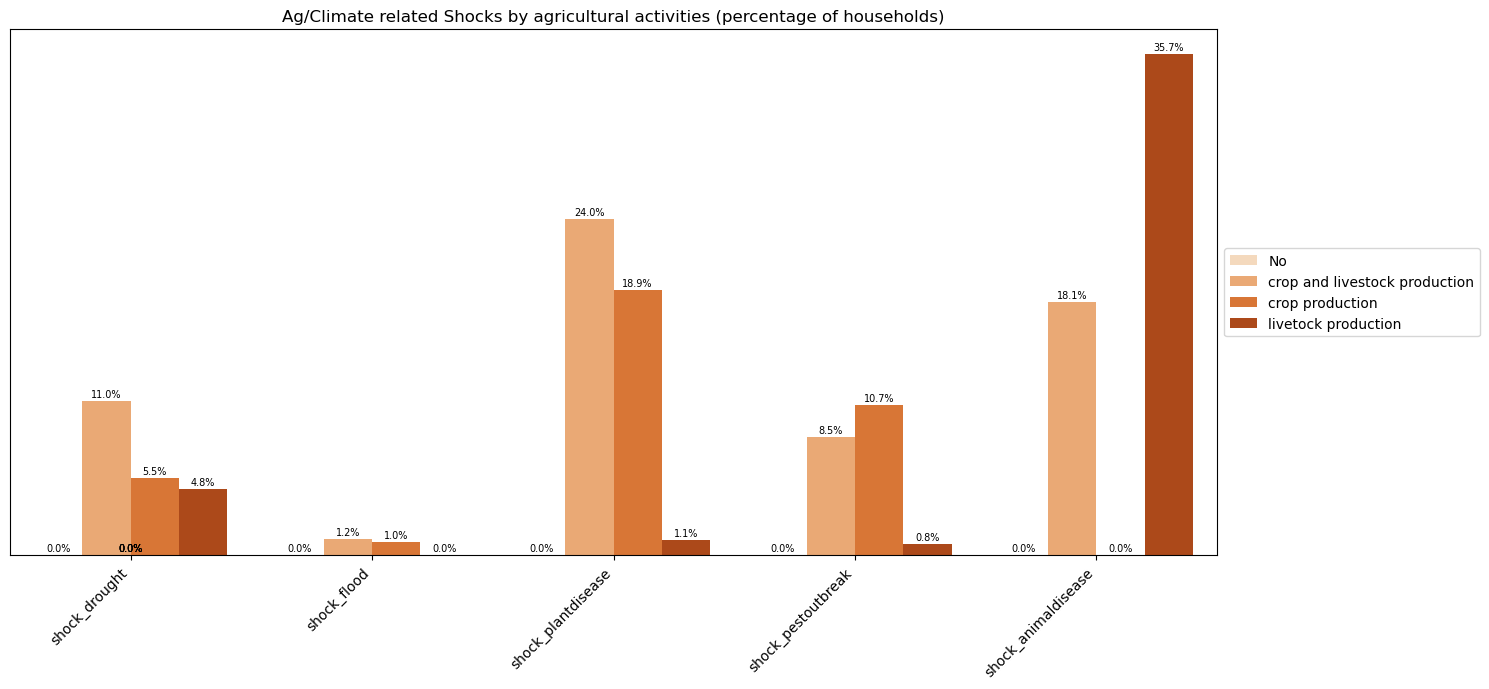

In [75]:
# Plot the top shocks experienced by agricultural activities
# Reshape the DataFrame to a 'melted' format for better visualization and analysis.
shock_melted_df = top_shocks_by_ag_activities.reset_index().melt(
    id_vars="hh_agricactivity", var_name="shock", value_name="percentage"
)
# Plot the horizontal bar chart
plt.figure(figsize=(15, 7))  # Set the figure size

# Create the bar plot with x and y axes swapped
ax = sns.barplot(
    data=shock_melted_df,  # Data for the plot
    y="percentage",  # Values for the y-axis
    x="shock",  # Values for the x-axis
    hue="hh_agricactivity",  # Grouping variable
    palette="Oranges",  # Color palette
)

# Set labels and title
ax.yaxis.set_ticks([])
# ax.xaxis.set_ticks([])
plt.xticks(rotation=45, ha='right', fontsize=10)

ax.set_xlabel("")  # X-axis label
ax.set_ylabel("")  # Y-axis label
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Legend
ax.set_title("Ag/Climate related Shocks by agricultural activities (percentage of households)")  # Plot title


for bar in ax.patches:
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    ax.annotate(f"{bar.get_height():.1f}%", 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 5),
                   textcoords='offset points')

plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot

* All the 12 most frequent shocks are associated with the agricultural activity.
* The shock from plant disease affected crop producing HHs the most, and, on the other hand, livestock producers was affected by animal disease the most.
* Shock from drought affected crop and livestock producing  and crop producing HHs most.
* Irrespective of the HH agricultural activity, all surveyed respondents experiences high shock from higher food prices and fuel prices.

**Engineer Now Variable `shock_climate`**

In [76]:
ag_climate_shock_cols = [
    "shock_drought",
    "shock_flood",
    "shock_plantdisease",
    "shock_pestoutbreak",
    "shock_animaldisease",
    "shock_violenceinsecconf"
]

# Use NumPy to check if all values in each row are 'Yes'
shock_climate = np.any(df[ag_climate_shock_cols].values == 1.0, axis=1)

# Assign the result to the new column 'any_dif' using .loc
df.loc[:, "shock_climate"] = shock_climate
df[[ "shock_drought",
    "shock_flood",
    "shock_plantdisease",
    "shock_pestoutbreak",
    "shock_animaldisease",
    "shock_violenceinsecconf",
    "shock_climate"]].isna().sum()

shock_drought              0
shock_flood                0
shock_plantdisease         0
shock_pestoutbreak         0
shock_animaldisease        0
shock_violenceinsecconf    0
shock_climate              0
dtype: int64

## **Crop (use only crop producing household)**

In [77]:
crop_producer_df = df.query("resp_iscropproducer == 'Yes'")
print("Crop Producers")
print(crop_producer_df.shape)


Crop Producers
(910, 222)


In [78]:
# Livestock Producer
ls_prod_df = df.query("resp_islsproducer == 'Yes'")
print("Livestock Producer")
print(ls_prod_df.shape)

Livestock Producer
(637, 222)


In [79]:
df["resp_iscropproducer"].value_counts(normalize=True)

resp_iscropproducer
Yes    0.643564
No     0.356436
Name: proportion, dtype: float64

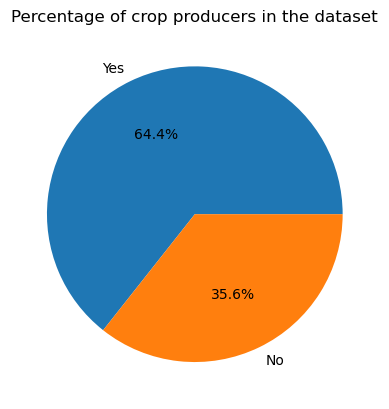

In [80]:
iscrp_producer = df.groupby("resp_iscropproducer", observed=True)["weight_final"].sum()

iscrp_producer = df["resp_iscropproducer"].value_counts(normalize=True)

plt.pie(iscrp_producer, labels=iscrp_producer.index, autopct="%1.1f%%")
plt.title("Percentage of crop producers in the dataset")
plt.show()

### Major Crop Produced

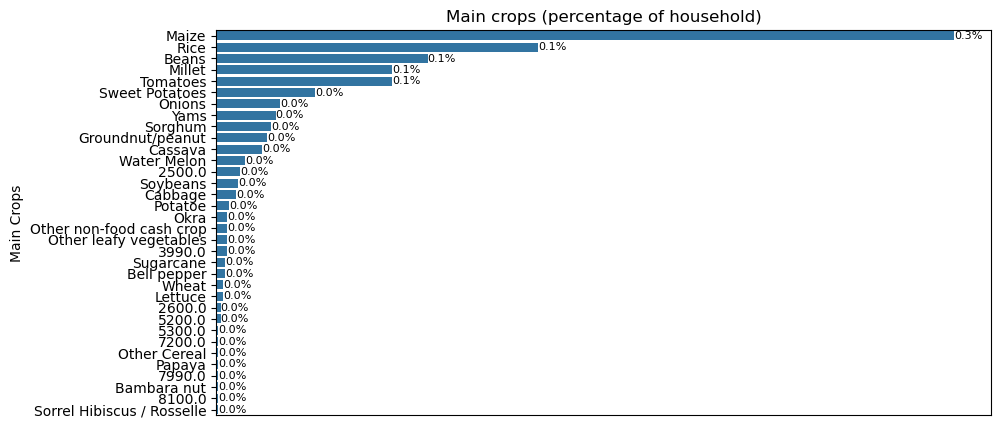

In [81]:
# Weighted count of the distribution of education in the dataset
crp_main = calculate_weighted_percentage(crop_producer_df, "crp_main", "weight_final")

plot_group_by_percentage(crp_main, 
                         "crp_main", 
                         ylabel="Main Crops",
                         title="Main crops (percentage of household)")

* The result of the major crop produced shows that 35 percent of the respondent who are identified as crop producers report **No Crop Production** in the past three months. This is an interesting find. Can we determine when they didn't produce?
* Millet is the most produced crop (21 percent) during the period in view. Followed by Maize, Sorghum and Rice respectively.
* Respondents did not report producing Cassava, and vegetables and wheats

**Top 5 Crops Grown by the Household**

In [82]:
crp_main.head()

,crp_main,weighted_sum,percentage
0,Rice,141.089735,0.146
1,Wheat,2.931861,0.003
2,Millet,77.231488,0.080
3,Sorghum,23.755728,0.025
4,Maize,324.257799,0.335


In [83]:
main_crops = crp_main.sort_values(by="percentage", ascending=False).reset_index(drop=True)
top_5_crops = list(main_crops.head(6)["crp_main"].values)
top_5_crops = top_5_crops[1:]
top_5_crops

['Rice', 'Beans', 'Tomatoes', 'Millet', 'Sweet Potatoes']

In [84]:
major_crop_by_state = compute_groupby(crop_producer_df, "state", "crp_main").loc[:, top_5_crops].fillna(0)

major_crop_by_state

crp_main,Rice,Beans,Tomatoes,Millet,Sweet Potatoes
state,,,,,
Adamawa,20.226059,11.341271,3.739704,7.237712,4.765594
Borno,10.465420,16.313272,10.147832,8.998176,3.179448
Katsina,12.443366,5.326443,9.998748,8.955003,5.125379
Yobe,15.800480,12.530587,6.822974,6.273989,5.286201
Zamfara,15.316550,4.169786,7.855442,7.302632,3.775453


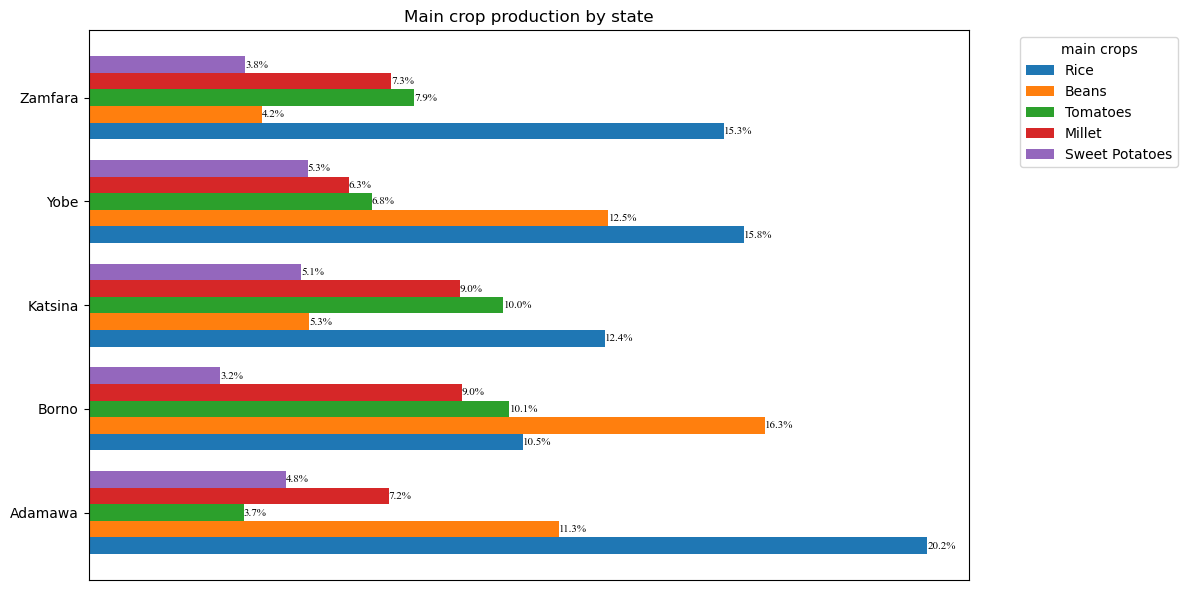

In [85]:

plot_grouped_data(major_crop_by_state,title="Main crop production by state", legend_title="main crops")

* 4 of the 5 states report high percentage of **No Crop Production**. With respondents who identified as crop producers in Adawawa reporting the highest (61 percent) No crop production during this period.
* Millet was reported as the most produced crop in all the states except Adamawa with 0 percent Millet production.
* Respondent in Yobe didn't report Maize production.

### Crop Cultivated Area

In [86]:
#  Count the number of NaN values in each column
nan_counts = crop_producer_df["crp_area_change"].isna().sum()
nan_counts

4

In [87]:
# Calculate the total number of values in each column
total_counts = crop_producer_df.shape[0]

# Calculate the percentage of NaN values in each column
nan_percentage = (nan_counts / total_counts) * 100
print("Percentage of NaN values in crp_area_change column:")
print(nan_percentage)

Percentage of NaN values in crp_area_change column:
0.43956043956043955


In [88]:
crop_producer_df["crp_area_change"].isna().sum()

4

In [89]:
# Household reporting drop in crop area compared to previous season
crop_area_change = calculate_weighted_percentage(crop_producer_df, 
                                                 "crp_area_change", 
                                                 weight_col="weight_final")
crop_area_change

,crp_area_change,weighted_sum,percentage
0,A lot more,32.243573,0.033
1,More,263.894188,0.274
2,Same,300.983623,0.312
3,Less,308.258221,0.320
4,A lot less,58.752996,0.061


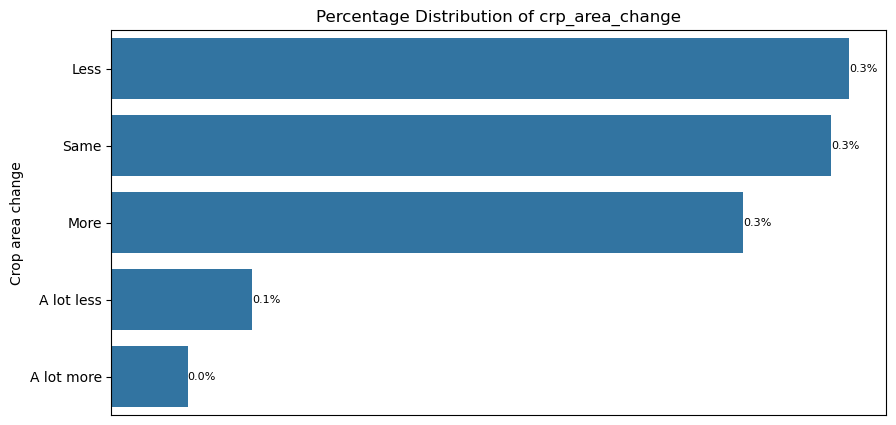

In [90]:
# Plot the bar chart
plot_group_by_percentage(crop_area_change, 
                         "crp_area_change", 
                         ylabel="Crop area change", 
                         title="Percentage Distribution of crp_area_change")

In [91]:
# Changes in crop area (percentage of crop producers) 
crp_area_change_by_state = compute_groupby(crop_producer_df, "state", "crp_area_change")
crp_area_change_by_state

crp_area_change,A lot more,More,Same,Less,A lot less
state,,,,,
Adamawa,0.965582,29.152326,29.410343,33.762988,6.708761
Borno,5.131279,22.423902,34.163110,34.093787,4.187922
Katsina,4.593158,29.122513,34.329476,27.660613,4.294240
Yobe,2.594014,22.314575,27.927047,39.226707,7.937657
Zamfara,2.479226,32.401742,27.153602,28.712250,9.253180


In [92]:
# Plot a stacked bar plot
def plot_crp_change_stacked(df, **kwargs):
    ax = df.plot(
        kind="bar", 
        stacked="stacked",
        width=0.8, figsize=(12, 6),
        
    )
    # Add values in the middle of each bar
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        
        # Check if the height is below a threshold
        if height < 5:
            height = 5  # Set a minimum height for the annotation
            
        ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')
        
    plt.title(kwargs["title"])
    plt.legend(title=kwargs["legend_title"], bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Remove y-axis ticks
    ax.yaxis.set_ticks([])
    
    plt.tight_layout()
    plt.show()

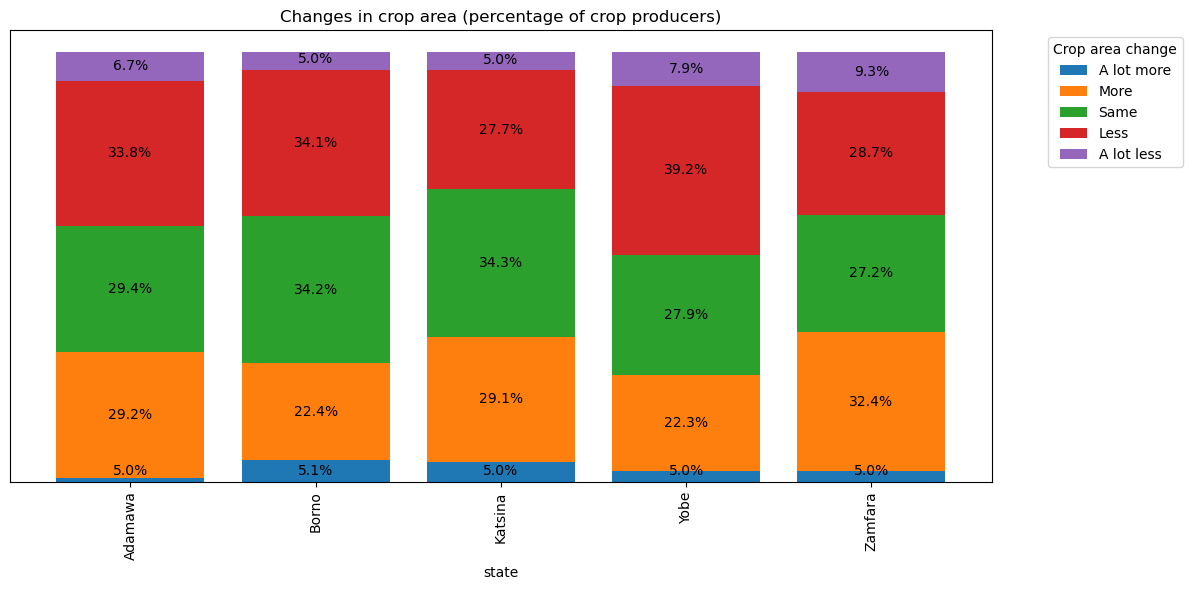

In [93]:
# Plot a stacked bar plot for crop area change
plot_crp_change_stacked(crp_area_change_by_state,
                             title="Changes in crop area (percentage of crop producers)",
                            legend_title="Crop area change")

In [94]:
# Defined a dictionary to map old income comp to new ones
area_change = {
    "Less": "Decrease",
    "A lot less": "Decrease",
    "More": "Increase",
    "A lot more": "Increase",
}

# Replace the old categories with new ones
df["crp_area_change_clean"] = df["crp_area_change"].replace(area_change)
crop_producer_df.loc[:,"crp_area_change_clean"] = crop_producer_df["crp_area_change"].replace(area_change)
crop_producer_df.loc[:,"crp_harv_change_clean"] = crop_producer_df["crp_harv_change"].replace(area_change)



/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_19464/510667977.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["crp_area_change_clean"] = df["crp_area_change"].replace(area_change)
/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_19464/510667977.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  crop_producer_df.loc[:,"crp_area_change_clean"] = crop_producer_df["crp_area_change"].replace(area_change)
/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_19464/510667977.py:11: SettingWithCopyWarning: 
A value is trying to be set

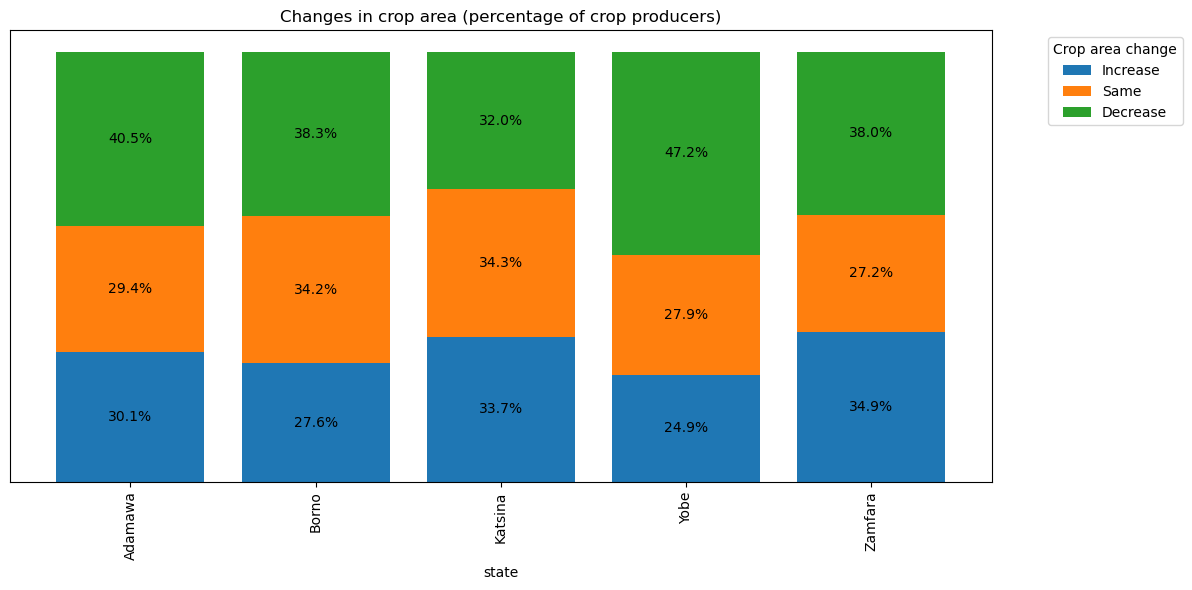

In [95]:
crp_area_change_by_state2 = compute_groupby(crop_producer_df, "state", "crp_area_change_clean")

plot_crp_change_stacked(crp_area_change_by_state2, 
                             title="Changes in crop area (percentage of crop producers)",
                            legend_title="Crop area change")

**Observation**
* Pronounced changes in crop area, with a reduction in cultivated area (64 percent) were reported in Zamfara,
in particular , while Borno, on the other hand, presented an increase in cultivated area (58%)
compared to the same period in a typical year.
* Kaduna presented highest proportion of respondent who reported "Same" crop area.

### Crop Harvest Area Change

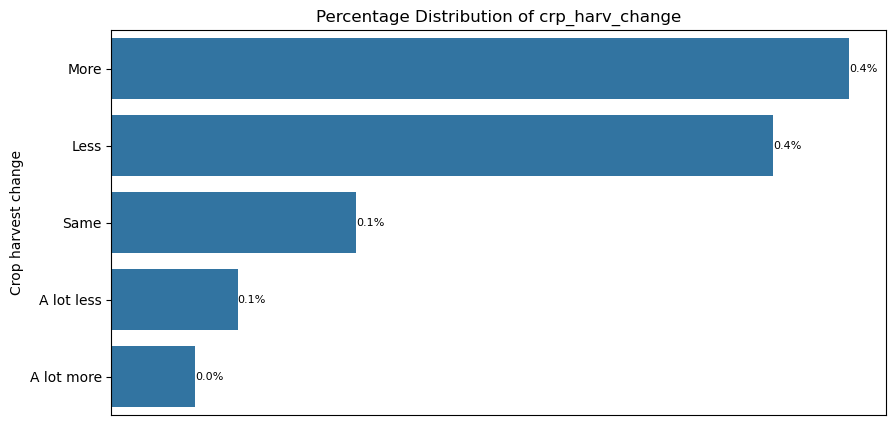

In [96]:
# Household reporting drop in crop area compared to previous season
crop_harv_change = calculate_weighted_percentage(
    crop_producer_df, "crp_harv_change", weight_col="weight_final"
)
# Plot the bar chart
plot_group_by_percentage(
    crop_harv_change,
    "crp_harv_change",
    ylabel="Crop harvest change",
    title="Percentage Distribution of crp_harv_change",
)


In [ ]:
# Changes in crop area (percentage of crop producers) 
crp_harv_change_by_state = compute_groupby(crop_producer_df, "state", "crp_harv_change")


# Plot a stacked bar plot for crop area change
plot_crp_change_stacked(crp_harv_change_by_state,
                             title="Changes in crop harvest area (percentage of crop producers)",
                            legend_title="Crop harvest area change")

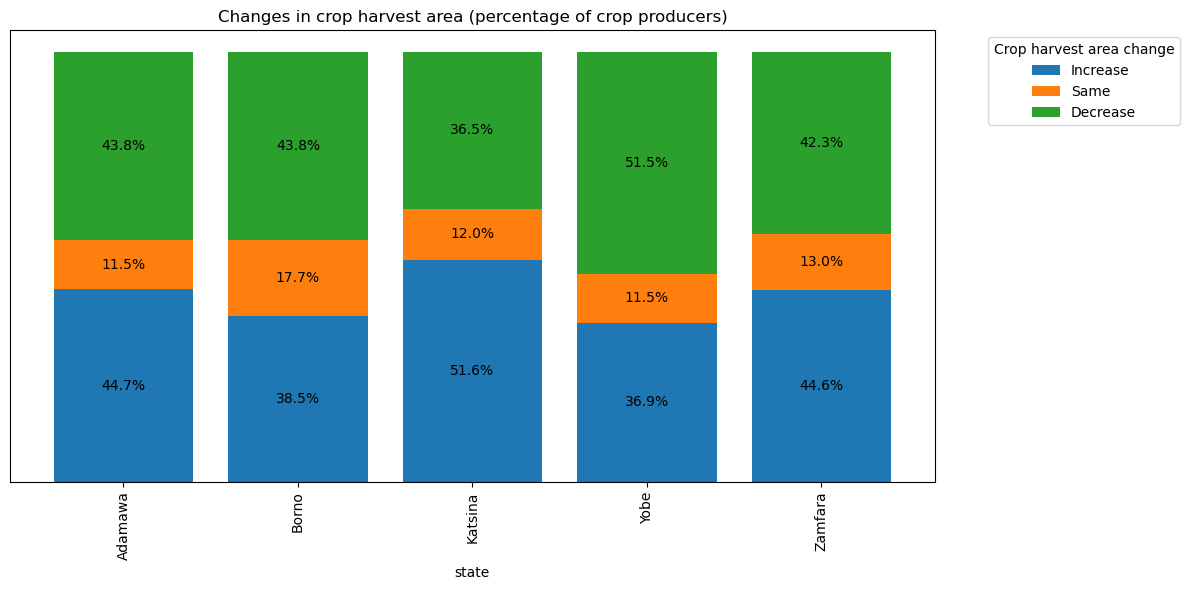

In [93]:
# Piviot by state and crp harvest changes
crp_harv_change_by_state2 = compute_groupby(crop_producer_df, "state", "crp_harv_change_clean")

# Plot change in harvest area by state
plot_crp_change_stacked(crp_harv_change_by_state2, 
                             title="Changes in crop harvest area (percentage of crop producers)",
                            legend_title="Crop harvest area change")

* Pronounced changes in harvest area, with a reduction in harvested area (84 percent) were reported in Yobe,
in particular , while Adamawa, on the other hand, presented an increase in cultivated area (51 percent)
compared to the same period in a typical year.
* Despite the increase in crop area, 58 percent of the households in Borno reported a reduction in harvest compared to a normal year. Similarly, crop producers in Zamfara and Yobe reported that their harvest was a lot less this year when compared to a typical year.

**Major crops (Millet, Maize, Sorghum, Rice and Soybeans ) by Cultivated Area**

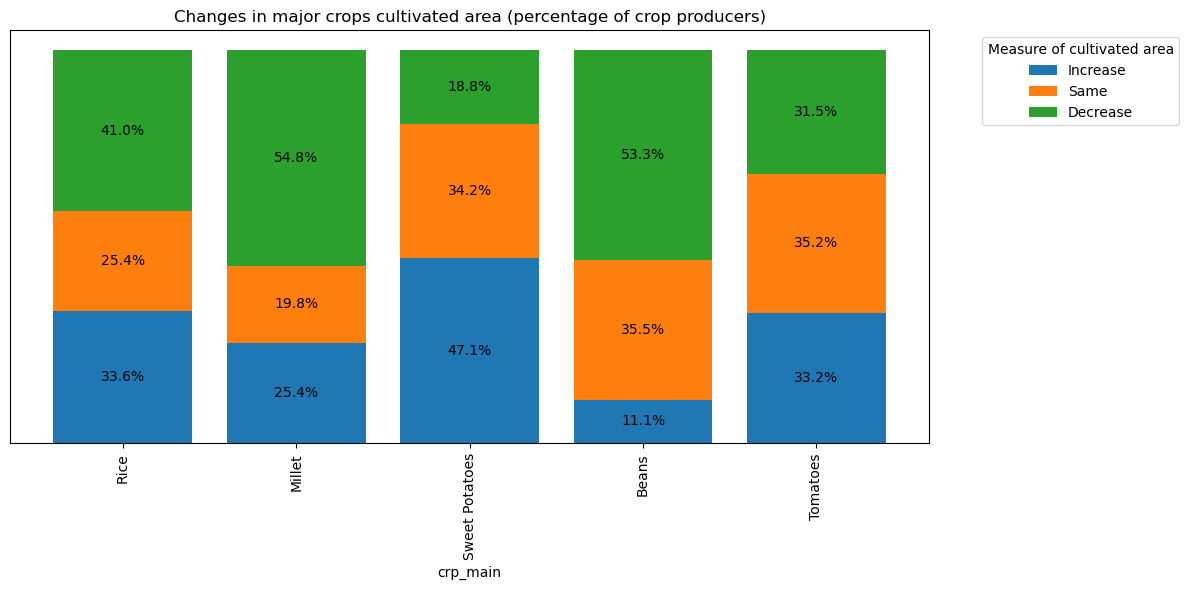

In [94]:
# Main crops by cultivated crop area
crop_by_crp_area = compute_groupby(
    crop_producer_df, "crp_main", "crp_area_change_clean"
)

crop_5_crp_area = crop_by_crp_area[crop_by_crp_area.index.isin(top_5_crops)]

plot_crp_change_stacked(
    crop_5_crp_area,
    title="Changes in major crops cultivated area (percentage of crop producers)",
    legend_title="Measure of cultivated area",
)


**Major crops (Millet, Maize, Sorghum, Rice and Soybeans ) by Harvest Area**

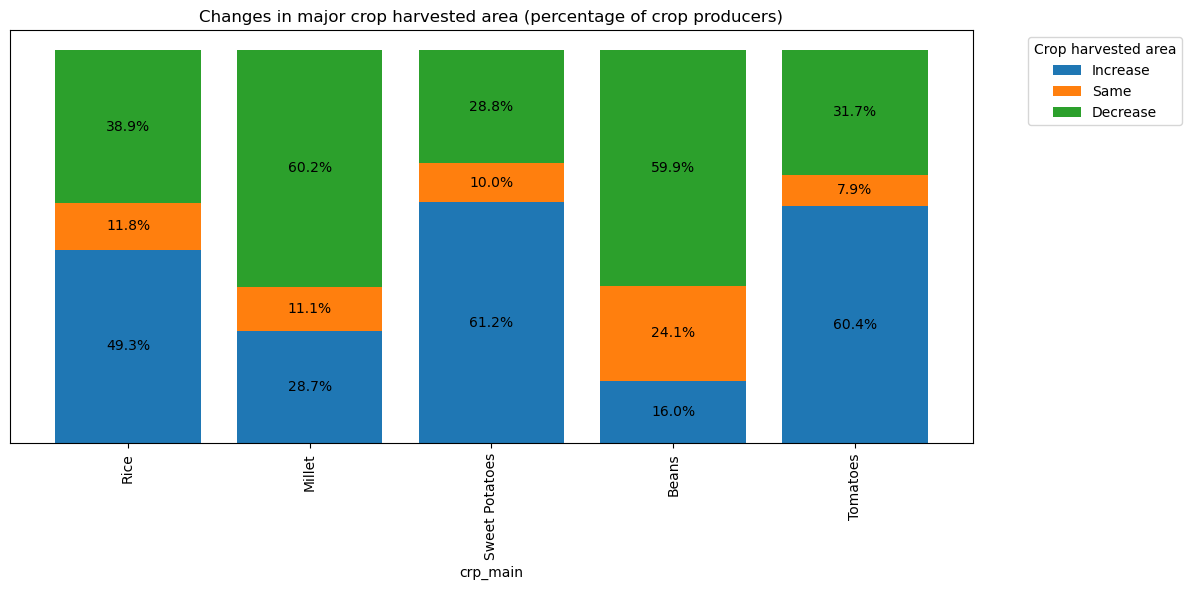

In [95]:

# Group harvest area by major crops
crop_by_harv_area = compute_groupby(crop_producer_df,  "crp_main", "crp_harv_change_clean")
# plot_grouped_data(harv_area_by_crop,title="Main crop by harvested area", legend_title="main crops")
crop_5_harv_area = crop_by_harv_area[crop_by_harv_area.index.isin(top_5_crops)]
plot_crp_change_stacked(crop_5_harv_area, 
                             title="Changes in major crop harvested area (percentage of crop producers)",
                            legend_title="Crop harvested area")


Millet, maize and sorghum reported a
reduction in harvest compared to a typical year of slightly less than 60 percent.

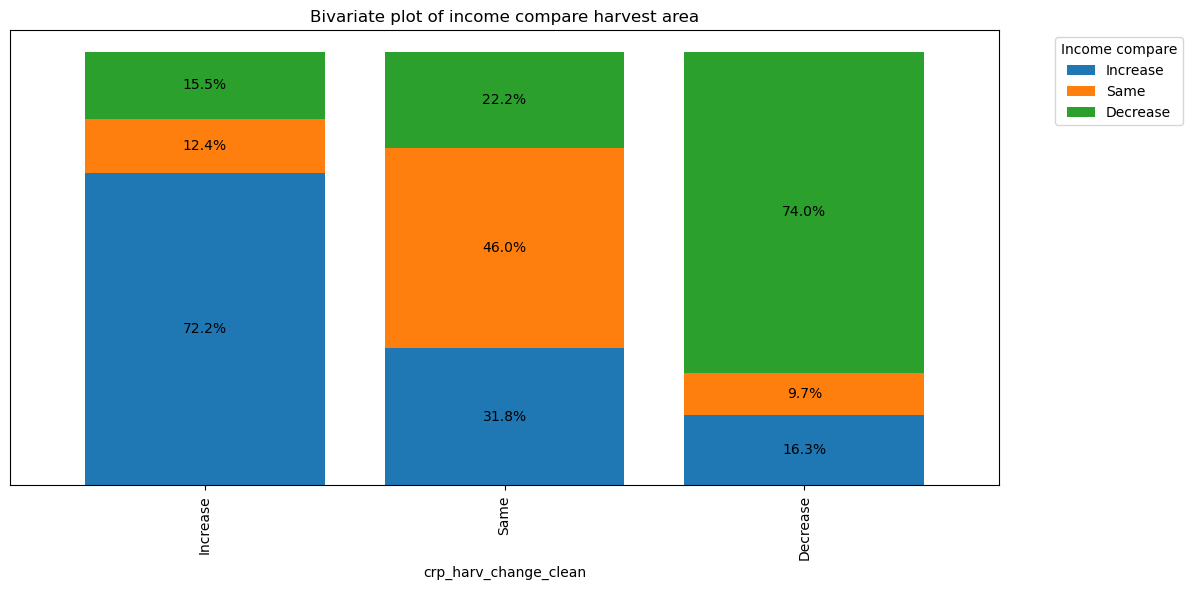

In [96]:
# Bivariate analysis of Income_compare with harvest area
# Is there a relationship between harvested area and income_compare. ie. does an increase in harvested correlate w

income_comp_wt_harv_area = compute_groupby(crop_producer_df, "crp_harv_change_clean", "income_comp_clean", )


plot_crp_change_stacked(income_comp_wt_harv_area, 
                  title="Bivariate plot of income compare harvest area", 
                 legend_title="Income compare")

* An increase in the main source of income was reported by 70% percent of the households who reported increase crop harvested area in
the three months preceding the survey.
* A decrease in the main source of income was reported by 58 percent of the households who reported decrease crop harvested area in the three months preceding the survey.
* Increase or decrease in harvest area is associated with increase or decrease in main income. **Is this relationship significant?** Yes it is as shown below

In [97]:
# Assuming df is your DataFrame containing the two categorical variables
# Create a contingency table (cross-tabulation) of the two variables
contingency_table = pd.crosstab(crop_producer_df['crp_harv_change_clean'], 
                                crop_producer_df['income_comp_clean'])

# Perform the chi-squared test

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)


Chi-squared statistic: 416.27365535505874
P-value: 8.467491607615657e-89
Degrees of freedom: 4


### Crop Production Difficulty 
Most production difficulty experienced

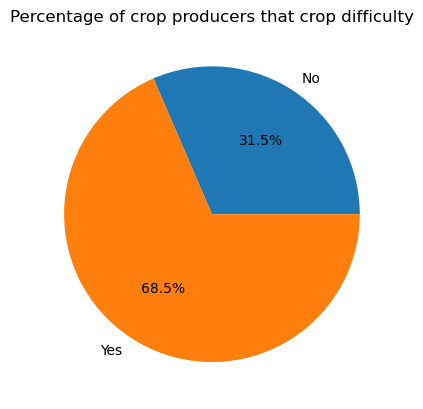

In [98]:
#? What percent of the surveyed household reported facing at least one shock
# Calculate the total weight
total_weight = crop_producer_df["weight_final"].sum()

# calculate total weighted sum of the crop production difficutlties
weight_sum_crp_dif = crop_producer_df.groupby("crp_proddif", observed=True)["weight_final"].sum()

# Calculate the weight percentage
weight_dif = (weight_sum_crp_dif / total_weight) * 100

# Create a pie chart

# Rename the index
weight_dif.index  = ["No", "Yes"]

plt.pie(weight_dif, labels=weight_dif.index, autopct="%1.1f%%")
plt.title("Percentage of crop producers that crop difficulty")
plt.show()

* About 94 percent of the households surveyed were crop producers.
* Crop production difficulties were reported by 75 percent of the crop producers

In [99]:
# # Main reported crop production difficulty

In [100]:
# Top Ten Crop production difficulty

top_crp_proddif = percentage_crp_prod_dif(crop_producer_df,
                                         start="crp_proddif_plant_disease",
                                         end="crp_proddif_other",
                                          n=10)
top_crp_proddif

,difficulty_type,value
0,crp_proddif_access_fertilize,44.013347
1,crp_proddif_plant_disease,37.238293
2,crp_proddif_lack_irrigation,32.920197
3,crp_proddif_pest_outbreak,22.227229
4,crp_proddif_animal_grazing,13.801877
5,crp_proddif_seed_quality,11.450868
6,crp_proddif_seed_quantity,10.456931
7,crp_proddif_access_labour,7.864741
8,crp_proddif_access_fuel,7.294266
9,crp_proddif_access_credit,7.263169


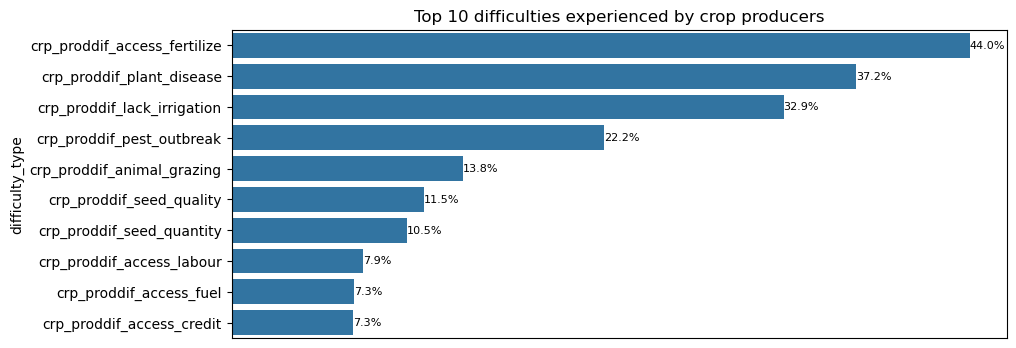

In [101]:
# Plot the shocks
plt.figure(figsize=(10, 4))
ax = sns.barplot(top_crp_proddif, x="value", y="difficulty_type",)

# Add percentage labels to the bars
ax.bar_label(ax.containers[0], fontsize=8, fmt="%1.1f%%") 

# Remove x-axis ticks and lables 
ax.xaxis.set_ticks([])
ax.set_xlabel("")
ax.set_title("Top 10 difficulties experienced by crop producers")

plt.show();

**Bivariate analysis of Top Five Crop Production Difficulty with state**

In [102]:
# Get all crop production difficulty columns
all_crp_diff_col = crop_producer_df.loc[:, "crp_proddif_plant_disease":"crp_proddif_other"].columns.tolist()

# Drop NaN values with reference to crop production difficulty variables
crp_prod = crop_producer_df.dropna(subset=all_crp_diff_col)


In [103]:
# Utitity function to compute all crop difficulty by state
# def all_top_crp_diff_by_state(df, subset:list):
#     crp_prod = df.dropna(subset=subset)
#     weighted_crp_diff = crp_prod[subset].astype(float).multiply(crp_prod["weight_final"], axis=0)
#     weighted_df = crp_prod[["state", "weight_final"]].join(weighted_crp_diff)
    
#     # Group by state and sum the weighted counts and weights
#     grouped = weighted_df.groupby("state", observed=True).sum()
    
#     # Calculate the percentage for each shock
#     for col in subset:
#         grouped[col] = (grouped[col] / grouped["weight_final"]) * 100   
#         # Keep only the percentage columns
#     percentage_columns = [col for col in subset]
#     all_shocks_by_state = grouped[percentage_columns]
#     return all_shocks_by_state


In [104]:
 # Top crop production difficulty by state

# Display the result
top_crp_diff_by_state = all_top_crp_diff_by_state(crp_prod, all_crp_diff_col)


# top_crp_proddif = percentage_crp_prod_dif(crop_producer_df, 5, weight_col="weight_final")
top_crp_proddif = percentage_crp_prod_dif(crop_producer_df,
                                         start="crp_proddif_plant_disease",
                                         end="crp_proddif_other",
                                          n=5)

# Top crop production difficulty columns
top_crp_diff_col = top_crp_proddif["difficulty_type"].to_list()
# Display the result
top_crp_diff_by_state = top_crp_diff_by_state[top_crp_diff_col]


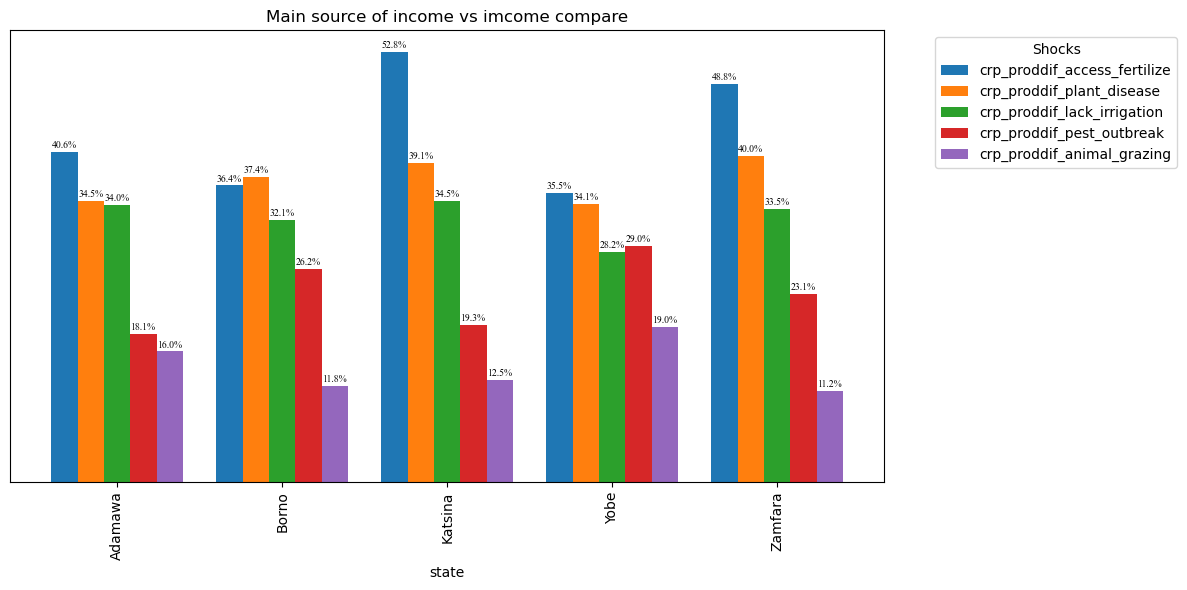

In [105]:
plot_grouped_data(
    top_crp_diff_by_state,
    kind="bar",
    title="Main source of income vs imcome compare",
    legend_title="Shocks",
)

**Observation**

* These included access to fertilizer (81 percent) – especially in Katsina (96 percent), Borno (84 percent) and Zamfara (71 percent).
* Access to credit (40 percent) – especially in Yobe (59 percent) and Borno (45 percent)
* Access to pesticides (31 percent) – especially in Borno (65 percent) and Katsina (26 percent)
* Not enough irrigation water (30 percent) – more prominent in Borno (65 percent) and Zamfara
(22 percent).
* Labour force was also reported as a difficulty by 23 percent of the respondent crop producers, in Borno, in particular, were half of the respondent farmers struggled to find a labour force.
* Pest diseases were reported by 44 percent of the crop producers in Adamawa. 

#### **Crop Producion Difficulties `(crop_proddif)` and Harvest Area (`crp_harv_change_clean`)**

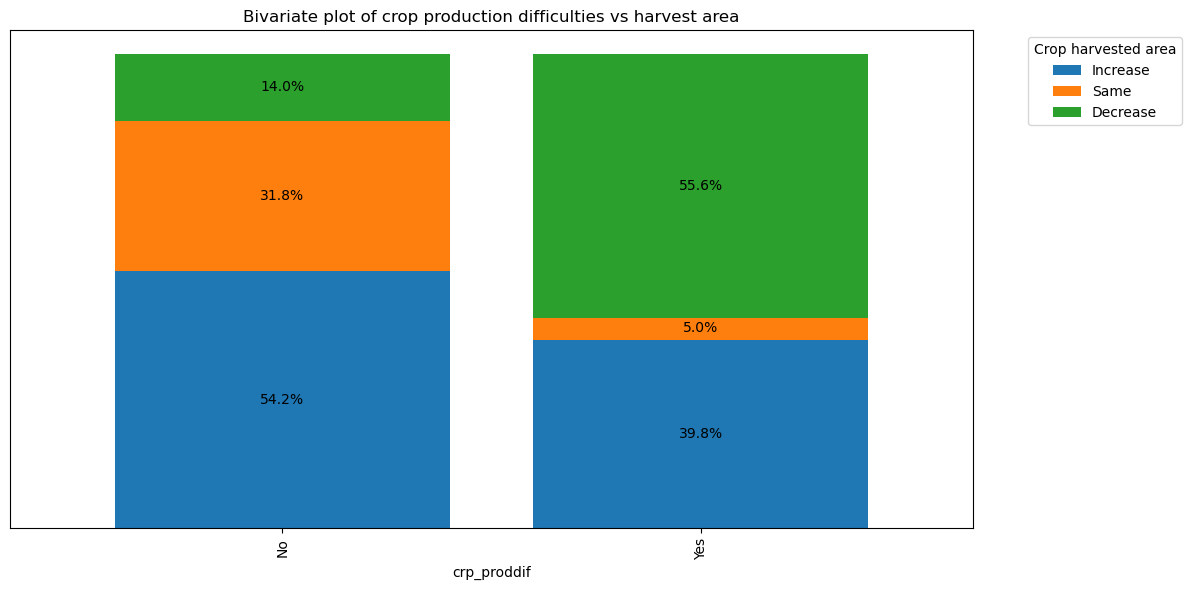

In [106]:
crp_proddiff_vs_harv_area = compute_groupby(crop_producer_df, "crp_proddif", "crp_harv_change_clean")


plot_crp_change_stacked(crp_proddiff_vs_harv_area, 
                  title="Bivariate plot of crop production difficulties vs harvest area", 
                 legend_title="Crop harvested area")

* The plot shows that household that reported crop production difficulties experience more decrease in their crop harvested area compared to those who didn't experience difficulty. Is the relationship significant?

In [107]:
# Create a contingency table (cross-tabulation) of the two variables
contingency_table = pd.crosstab(crp_prod["crp_proddif"], 
                                crp_prod["crp_harv_change_clean"])

# Perform the chi-squared test

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 0.0
P-value: 1.0
Degrees of freedom: 0


In [108]:
# Top crop difficulty relationship with crop harvested area
harv_by_cropdiff_cols = top_crp_diff_col + ["crp_harv_change_clean"]
harv_by_crp_prodiff = crp_prod[harv_by_cropdiff_cols]

melted_harv_by_crp_prodiff = pd.melt(harv_by_crp_prodiff, 
                                     id_vars="crp_harv_change_clean", 
                                     var_name="crp_proddiff", 
                                     value_name="value").dropna(subset=["crp_harv_change_clean"])

melted_harv_by_crp_prodiff["value"] = melted_harv_by_crp_prodiff["value"].astype(int)
# Calculate the percentage of each class in 'crp_harv_change2' for each column
percentage_harv_by_crp_proddiff = (melted_harv_by_crp_prodiff
                                   .groupby(['crp_proddiff', 'crp_harv_change_clean'], 
                                        observed=False)["value"].mean()
                                   .unstack()
                                   .apply(lambda x: x / x.sum(), axis=1) * 100
                                  )
percentage_harv_by_crp_proddiff

crp_harv_change_clean,Increase,Same,Decrease
crp_proddiff,,,
crp_proddif_access_fertilize,33.731394,27.489082,38.779525
crp_proddif_animal_grazing,31.679863,44.021646,24.298490
crp_proddif_lack_irrigation,29.519456,37.567845,32.912699
crp_proddif_pest_outbreak,28.052950,33.784197,38.162853
crp_proddif_plant_disease,34.832333,20.743821,44.423845


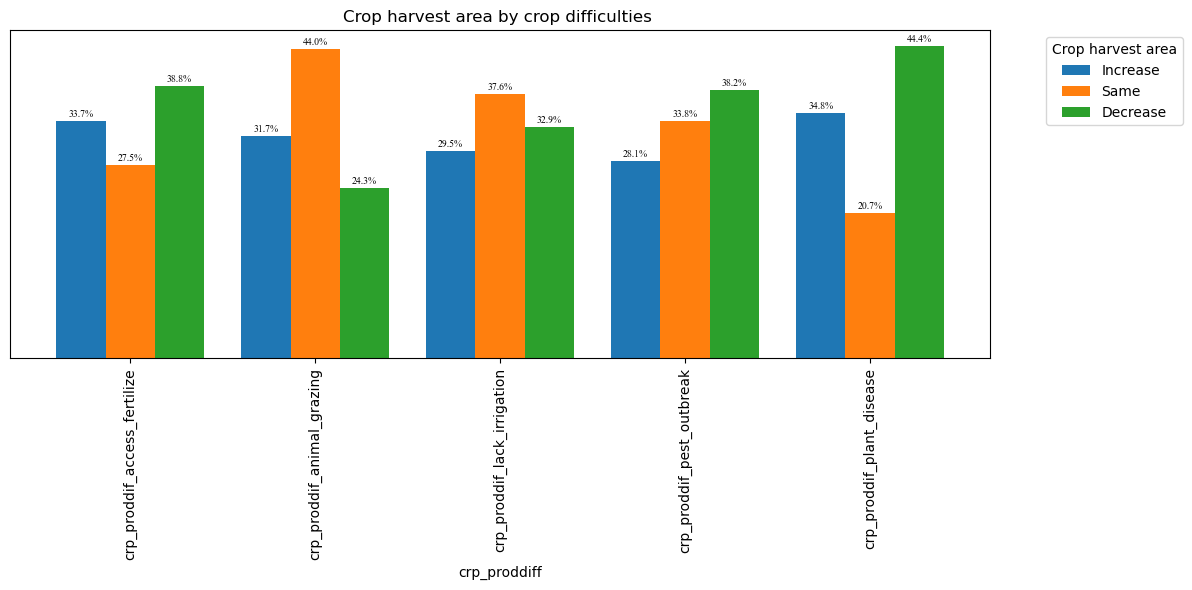

In [109]:
plot_grouped_data(percentage_harv_by_crp_proddiff,
                  kind="bar",
                  title="Crop harvest area by crop difficulties ", 
                  legend_title="Crop harvest area")


* Households who reported crop production difficulty reported a decrease in crop harvest area (74%). Is this observation (statistically significant)?


#### **Crop Production difficulty (`crp_prod_diff`) and Main Income**

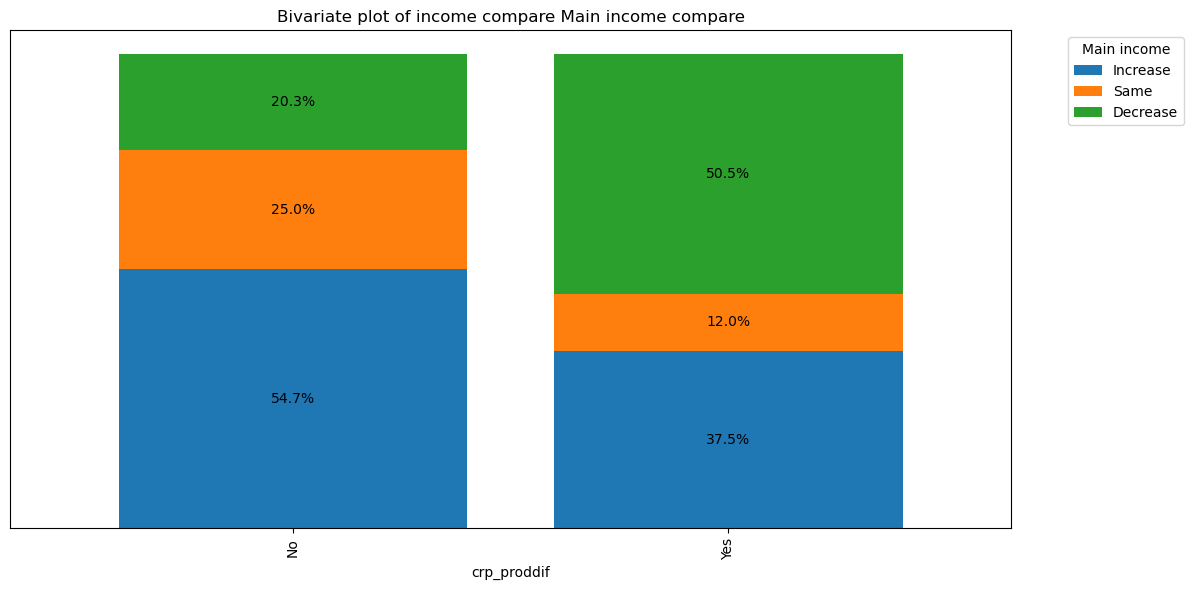

In [110]:
crp_proddiff_vs_income_compare = compute_groupby(crop_producer_df, 
                                                 "crp_proddif", 
                                                 "income_comp_clean"
                                                )


plot_crp_change_stacked(crp_proddiff_vs_income_compare, 
                  title="Bivariate plot of income compare Main income compare", 
                 legend_title="Main income")

In [111]:
# Create a contingency table (cross-tabulation) of the two variables
contingency_table = pd.crosstab(crop_producer_df['crp_proddif'], crop_producer_df['income_comp_clean'])

# Perform the chi-squared test

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 83.90771254044853
P-value: 6.021042979136932e-19
Degrees of freedom: 2


* Households who reported crop production difficulty reported a decrease in main income. Is this observation (statistically significant)?


#### **Acces to fertilizer `crp_proddiff_access_fertilzer` vs crop harvested area (`crp_harv_change_clean`)**

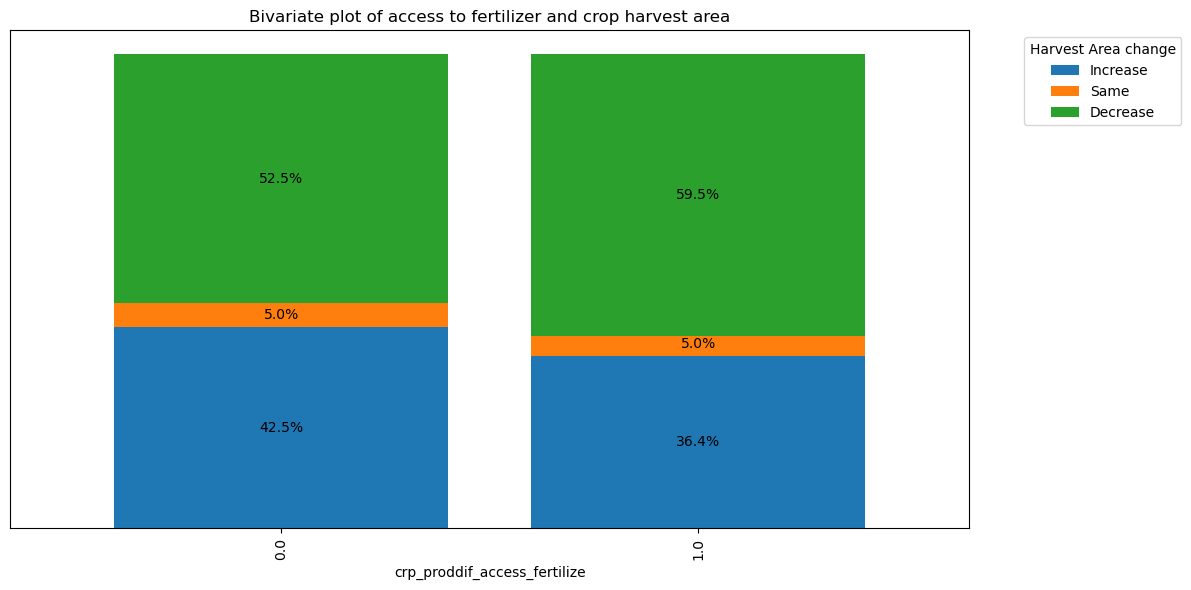

In [112]:
# bivariate analysis of crp_proddif_access_fertilize and crop harvested area

res = compute_groupby(crop_producer_df, "crp_proddif_access_fertilize","crp_harv_change_clean")


plot_crp_change_stacked(res, 
                  title="Bivariate plot of access to fertilizer and crop harvest area", 
                 legend_title="Harvest Area change")


In [113]:

# Create a contingency table (cross-tabulation) of the two variables
contingency_table = pd.crosstab(crop_producer_df['crp_proddif_access_fertilize'], 
                                crop_producer_df['crp_harv_change_clean'])

# Perform the chi-squared test

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 3.4419139926487103
P-value: 0.17889486423812084
Degrees of freedom: 2


* There is slight proportion of household that experience decrease in harvested area as a result of difficulty accessing fertilizer. And the difference is statistically siginicant. 


#### **`crp_proddiff_access_fertilzer` vs (`crp_area_change_clean`)**

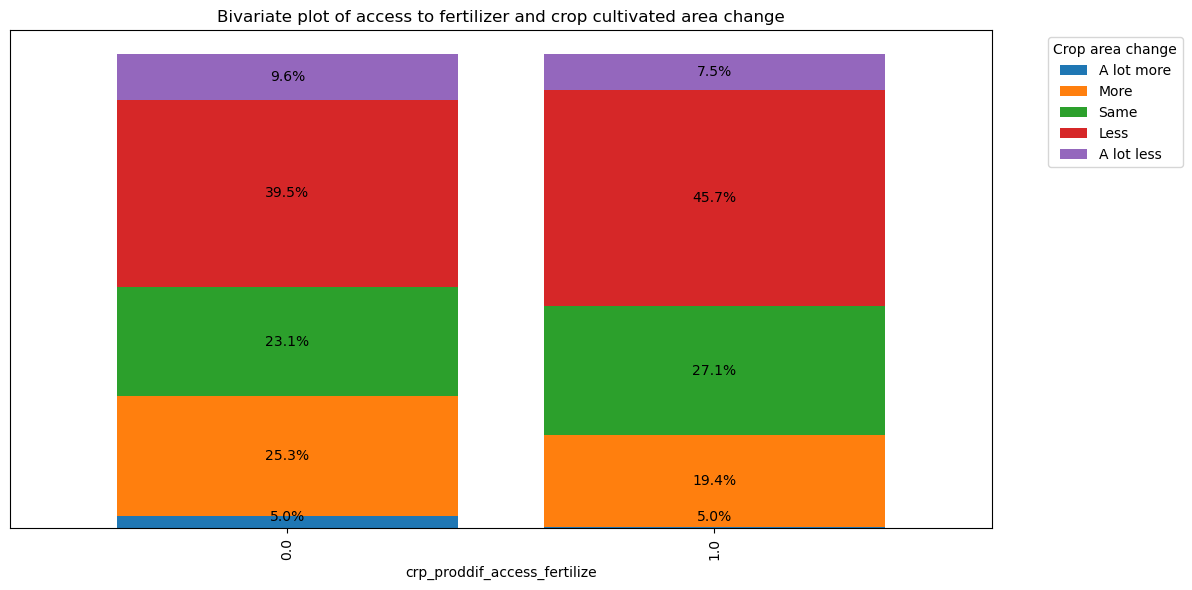

Chi-squared statistic: 6.586723577323641
P-value: 0.15940745750327517
Degrees of freedom: 4


In [114]:
# bivariate analysis of crp_proddif_access_fertilize and crop harvested area

res = compute_groupby(crop_producer_df, "crp_proddif_access_fertilize","crp_area_change")


plot_crp_change_stacked(res, 
                  title="Bivariate plot of access to fertilizer and crop cultivated area change", 
                 legend_title="Crop area change")


# Create a contingency table (cross-tabulation) of the two variables
contingency_table = pd.crosstab(crop_producer_df['crp_proddif_access_fertilize'], 
                                crop_producer_df['crp_area_change'])

# Perform the chi-squared test

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

* The relationship between crop production difficulty and fies level is not statiscally significant.

#### **Crop Sales Difficulties**
Analyze crop producers that faced difficulties selling crops.

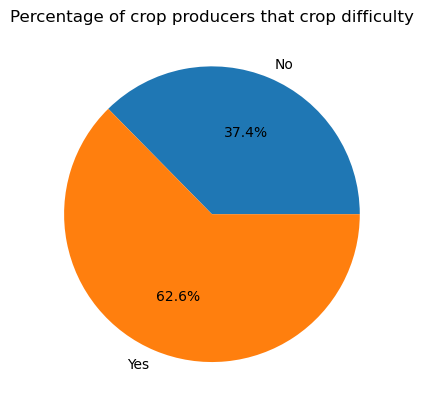

In [115]:
# Calculate the total weight
total_weight = crop_producer_df["weight_final"].sum()

# calculate total weighted sum of the crop production difficutlties
weight_sum_crp_salesdif = crop_producer_df.groupby("crp_salesdif", observed=True)["weight_final"].sum()

# Calculate the weight percentage
weight_crp_salesdif = (weight_sum_crp_salesdif / total_weight) * 100

# Create a pie chart

# Rename the index
weight_crp_salesdif.index  = ["No", "Yes"]

plt.pie(weight_crp_salesdif, labels=weight_crp_salesdif.index, autopct="%1.1f%%")
plt.title("Percentage of crop producers that crop difficulty")

plt.show()

In [116]:
# Get all the crop sales difficulty
crop_salesdif_cols = crop_producer_df.loc[:, 
"crp_saledif_marketing_cost":"crp_saledif_other"].columns.tolist()
crop_salesdif_cols

['crp_saledif_marketing_cost',
 'crp_saledif_damage_losses',
 'crp_saledif_low_demand',
 'crp_saledif_pay_delay',
 'crp_saledif_low_price',
 'crp_saledif_processing',
 'crp_saledif_competition',
 'crp_saledif_other']

In [117]:
# Top Ten Crop sales  difficulties
top_crp_salesdif_df = percentage_crp_prod_dif(
    crop_producer_df, start="crp_saledif_marketing_cost", end="crp_saledif_other", n=5
)
top_crp_salesdif_df

,difficulty_type,value
0,crp_saledif_marketing_cost,69.454450
1,crp_saledif_low_price,34.350643
2,crp_saledif_low_demand,32.667451
3,crp_saledif_damage_losses,27.319939
4,crp_saledif_pay_delay,25.993189


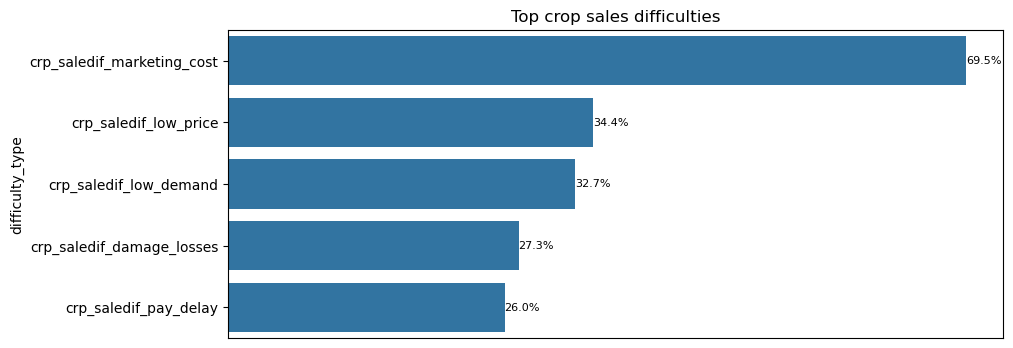

In [118]:
# The main crop sale difficulties
plot_diff_variables(top_crp_salesdif_df, "Top crop sales difficulties")

**Observation**

* About 54 percent of the crop producers faced difficulties selling crops. The main crop sales
difficulties reported were high transport or other marketing costs (`crp_saledif_marketing_cost`) (89 percent) in the northeast states.
* Payment delays from traders and buyers (36 percent), and
* Difficulty processing products (22 percent).

In [119]:
# Crop sales difficulty by states

# All Sale difficulty by state
all_crp_salesdif_df = all_top_crp_diff_by_state(crp_prod, crop_salesdif_cols)

# Top Five Crop sales  difficulties
top_crp_salesdif_df = percentage_crp_prod_dif(
    crop_producer_df, start="crp_saledif_marketing_cost", end="crp_saledif_other", n=5
)


# Top crop sale difficulty columns
top_crp_salesdif_col= top_crp_salesdif_df["difficulty_type"].to_list()

# Subset the top sale difficulties
top_crp_salesdif_by_state = all_crp_salesdif_df[top_crp_salesdif_col]

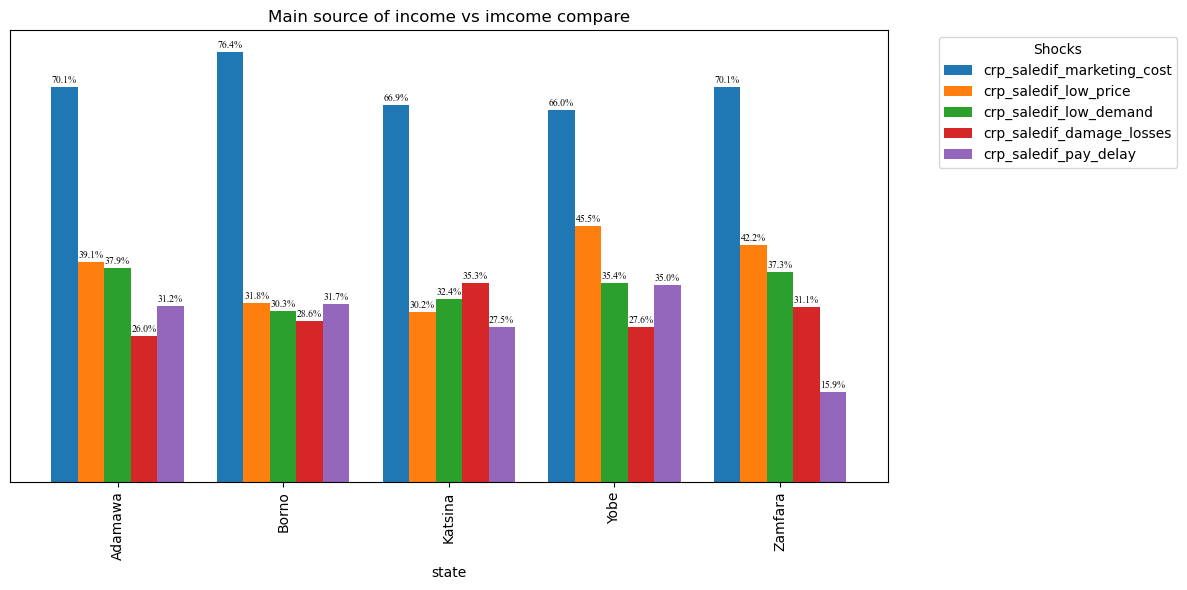

In [120]:
plot_grouped_data(
    top_crp_salesdif_by_state,
    kind="bar",
    title="Main source of income vs imcome compare",
    legend_title="Shocks",
)

**Observation**

* All the states reports crop sales difficulties from high transport or other marketing costs.

#### **Crop sales prices compared to a normal year**
Household reporting crop sales price compared to a normal year

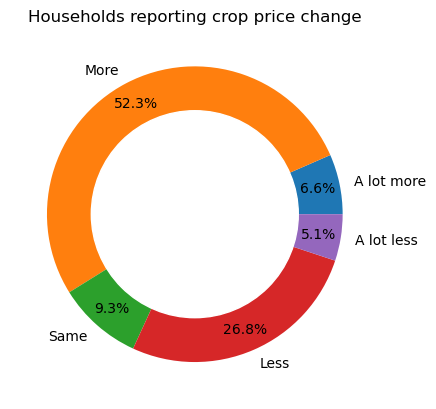

In [121]:
# Household reporting crop sales price compared to a normal year

# Group by 'crp_salesprice' and sum the weights
crp_salesprice_weight_sum = (
    crop_producer_df.groupby("crp_salesprice", observed=True)["weight_final"]
    .sum()
    .reset_index()
)

# Calculate the total weight
total_weight = crp_salesprice_weight_sum["weight_final"].sum()

# Calculate the proportion of each category
crp_salesprice_weight_sum["proportion"] = (
    crp_salesprice_weight_sum["weight_final"] / total_weight
)

names = crp_salesprice_weight_sum["crp_salesprice"].unique()
size = crp_salesprice_weight_sum.proportion.values

# Create a circle at the center of the plot
plt.pie(size, labels=names, autopct="%1.1f%%", pctdistance=0.85)

my_circle = plt.Circle((0, 0), 0.7, color="white")

# Custom wedges
# plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
# Adding Title of chart
plt.title("Households reporting crop price change")
plt.show()


In [122]:
crp_by_sale_price = compute_groupby(crop_producer_df, "crp_main", "crp_salesprice")


In [123]:
top_crp_by_price = crp_by_sale_price.query("crp_main == @top_5_crops")
top_crp_by_price

crp_salesprice,A lot more,More,Same,Less,A lot less
crp_main,,,,,
Rice,5.900158,54.064648,2.975359,29.182790,7.877044
Millet,0.000000,50.346164,5.792486,36.566663,7.294687
Sweet Potatoes,9.991999,67.234968,7.240757,13.178984,2.353292
Beans,4.971254,27.875076,21.842691,42.495328,2.815652
Tomatoes,13.503762,60.884957,1.351003,17.422083,6.838195


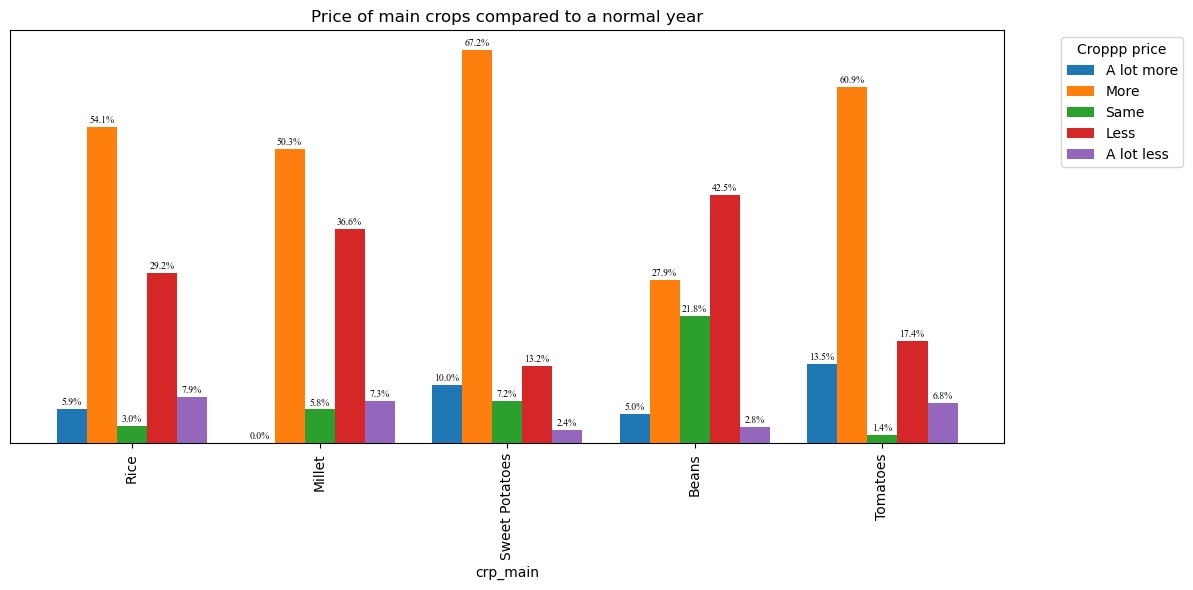

In [124]:
plot_grouped_data(top_crp_by_price, 
                  kind="bar",
                  title="Price of main crops compared to a normal year",
                 legend_title="Croppp price")

**Obersation**

* For 59.5 percent of households reports that crop prices were A lot more than the average in the previous season.
* All top 5 cultivated crops we were reported to be sold at 'a lot'  higher price compared to a normal year by more households

## **Livestock Production and Difficulty**

In [125]:
# is_livestock_producer = df.groupby("resp_islsproducer", observed=True)["weight_final"].sum()
ls_producer_df = df.query("resp_islsproducer == 'Yes'")

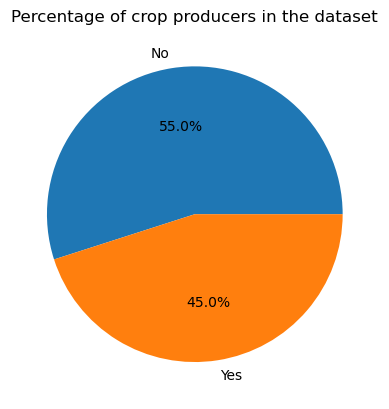

In [126]:
is_livestock_producer = df["resp_islsproducer"].value_counts(normalize=True)

plt.pie(is_livestock_producer, labels=is_livestock_producer.index, autopct="%1.1f%%")
plt.title("Percentage of crop producers in the dataset")
plt.show()

* About 56 percent of the households surveyed were livestock producers.

### Animals Raise By the Surveyed Households

In [127]:
ls_main_percent = calculate_weighted_percentage(ls_producer_df, "ls_main", "weight_final")
ls_main_percent = ls_main_percent.sort_values("percentage", ascending=False, ignore_index=True)


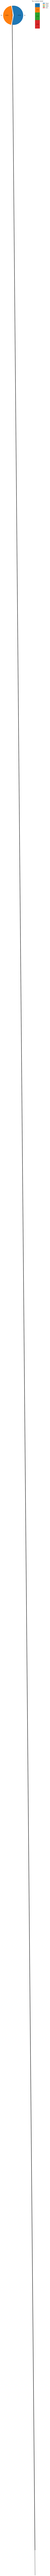

In [128]:
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = list(is_livestock_producer)
labels = list(is_livestock_producer.index)
explode = [0, 0.1]

# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(
    overall_ratios, autopct="%1.1f%%", startangle=angle, labels=labels, explode=explode
)

# # bar chart parameters
# ls_main_ratio = list(ls_producer_df["ls_main"].value_counts(normalize=True).values)[:4]
# ls_main_label = list(ls_producer_df["ls_main"].value_counts(normalize=True).index)[:4]

ls_main_percent = calculate_weighted_percentage(ls_producer_df, "ls_main", "weight_final")
ls_main_percent = ls_main_percent.sort_values("percentage", ascending=False, ignore_index=True)


ls_main_label = ls_main_percent["ls_main"].tolist()[:4]
ls_main_ratio = (ls_main_percent["percentage"]/100).tolist()[:4]


bottom = 1
width = 0.2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(ls_main_ratio, ls_main_label)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, label=label, alpha=1 + 0 * j)
    ax2.bar_label(bc, labels=[f"{height:.1%}"], label_type="center")

ax2.set_title("Top 4 animal raised")
ax2.legend()
ax2.axis("off")
ax2.set_xlim(-2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(ls_main_ratio)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(
    xyA=(-width / 2, bar_height),
    coordsA=ax2.transData,
    xyB=(x, y),
    coordsB=ax1.transData,
)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(
    xyA=(-width / 2, 0), coordsA=ax2.transData, xyB=(x, y), coordsB=ax1.transData
)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()


In [129]:
# Top 5 animal raised ( To confirm the plot above)
ls_main_percent = calculate_weighted_percentage(ls_producer_df,
                                                "ls_main", 
                                                "weight_final").sort_values("percentage", ascending=False)
ls_main_percent.head(5)

,ls_main,weighted_sum,percentage
2,Goat,226.182511,0.327
0,Cattle,205.677691,0.298
4,Poulty,140.148651,0.203
5,Sheep,104.984916,0.152
7,Swine,6.333370,0.009


* 56 percent of the household surveyed are livestock producer.
* Goat and sheep are the most raised animals at 39.2 and 26.2 percent respectivitely

### Livestock Production Difficulties
What are some of the most prevalent difficulties experienced by the surveyed household

In [130]:
ls_producer_df.shape

(637, 223)

In [131]:
ls_proddiff_df = df.dropna(subset="ls_proddif")
ls_proddiff_df.shape

(637, 223)

**What percentage of the household experienced livestock production difficulty?**

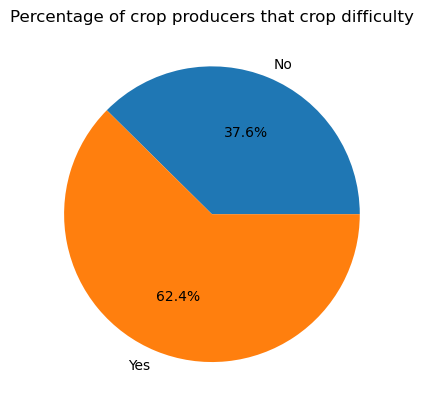

In [132]:
# Calculate the total weight
ls_proddiff_total_weight = ls_proddiff_df["weight_final"].sum()

# calculate total weighted sum of the crop production difficutlties
weight_sum_ls_proddiff = ls_proddiff_df.groupby("ls_proddif", observed=True)["weight_final"].sum()

# Calculate the weight percentage
weight_ls_proddiff = (weight_sum_ls_proddiff / ls_proddiff_total_weight) * 100

# Create a pie chart

# Rename the index
weight_ls_proddiff.index  = ["No", "Yes"]

plt.pie(weight_ls_proddiff, labels=weight_ls_proddiff.index, autopct="%1.1f%%")
plt.title("Percentage of crop producers that crop difficulty")
plt.show()

* About 56 percent of the households surveyed were livestock producers.
* Among them, 78 percent experienced livestock production difficulties.

In [133]:
# Livestock production difficulty columns
ls_proddif_col = [col for col in ls_proddiff_df.columns if col.startswith("ls_proddif")]
ls_proddif_col

['ls_proddif',
 'ls_proddif_feed_purchase',
 'ls_proddif_access_pasture',
 'ls_proddif_access_water',
 'ls_proddif_vet_serv',
 'ls_proddif_vet_input',
 'ls_proddif_diseases',
 'ls_proddif_theft',
 'ls_proddif_access_market',
 'ls_proddif_access_credit',
 'ls_proddif_access_labour',
 'ls_proddif_other']

**Main reported livestock production difficulties**

In [134]:
# Top Ten Crop production difficulty

top_ls_proddiff = percentage_crp_prod_dif(ls_proddiff_df,
                                         start="ls_proddif_feed_purchase",
                                         end="ls_proddif_other",
                                          n=11)
# top_ls_proddiff

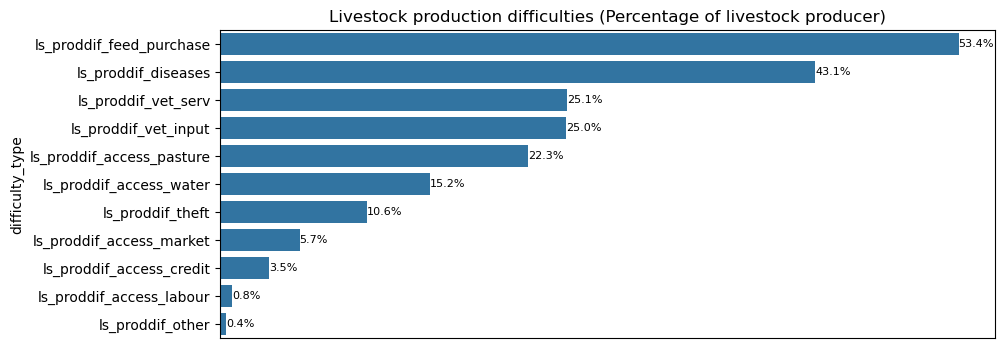

In [135]:
# Livestokc production difficulties
plot_diff_variables(top_ls_proddiff, 
                    "Livestock production difficulties (Percentage of livestock producer)")

**# Top crop livestock production difficulty by state**

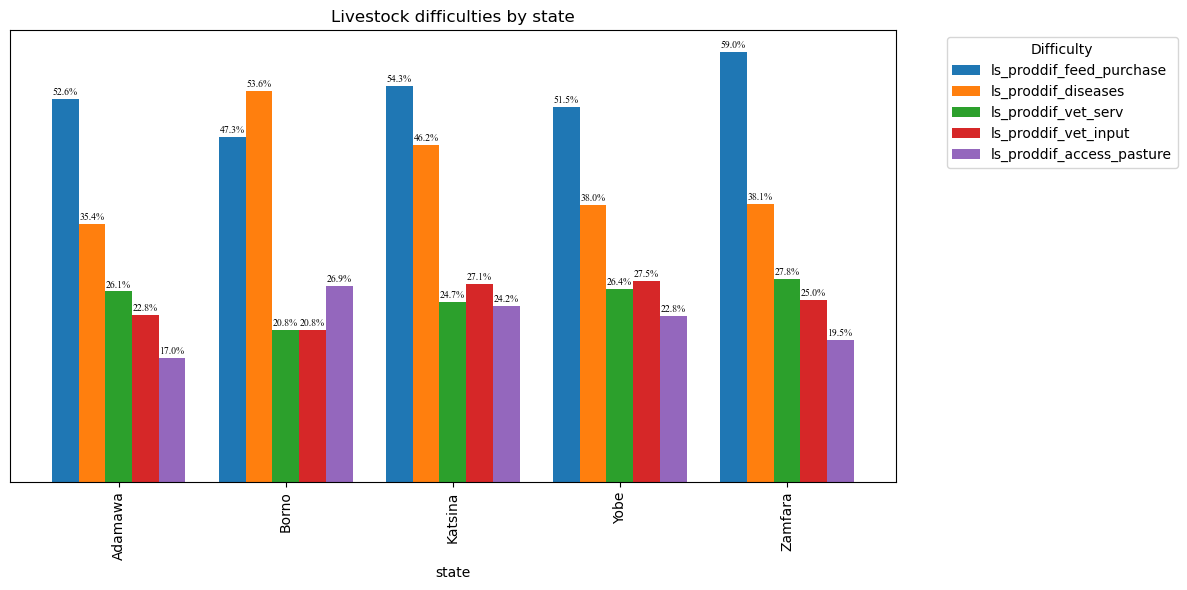

In [136]:
# Get all livestock production difficulties cols
all_ls_proddiff_col = ls_proddif_col[1:]


# Top 5 livestock production difficulty
top_ls_proddiff = percentage_crp_prod_dif(ls_proddiff_df,
                                         start="ls_proddif_feed_purchase",
                                         end="ls_proddif_other",
                                          n=5)
# Top crop production difficulty columns
top_ls_proddiff_col = top_ls_proddiff["difficulty_type"].to_list()


# Get all difficulty by state
top_ls_proddiff_by_state = all_top_crp_diff_by_state(ls_proddiff_df, all_ls_proddiff_col)

# Top difficulty by state
top_ls_proddiff_by_state = top_ls_proddiff_by_state[top_ls_proddiff_col]


plot_grouped_data(
    top_ls_proddiff_by_state,
    kind="bar",
    title="Livestock difficulties by state",
    legend_title="Difficulty",
)

* 78 percent experienced livestock production difficulties. The main livestock production
difficulties experienced were difficulties purchasing feed (67 percent) – mostly reported in Yobe (94 percent), Katsina (64 percent) and Zamfara (56 percent).
* The most reported livestock production difficulty reported in Borno is Vet service and vet inputs followed by purchasing feed.

### Livestock Sale Difficulty

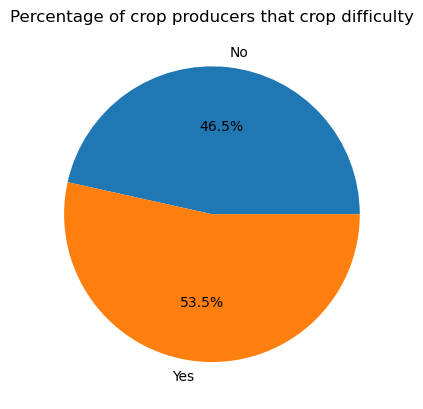

In [137]:
ls_salediff_df = df.dropna(subset="ls_salesdif")

# Calculate the total weight
ls_salediff_total_weight = ls_salediff_df["weight_final"].sum()

# calculate total weighted sum of the crop production difficutlties
weight_sum_ls_salediff = ls_salediff_df.groupby("ls_salesdif", observed=True)["weight_final"].sum()

# Calculate the weight percentage
weight_ls_salediff = (weight_sum_ls_salediff / ls_salediff_total_weight) * 100

# Create a pie chart

# Rename the index
weight_ls_salediff.index  = ["No", "Yes"]

plt.pie(weight_ls_salediff, labels=weight_ls_salediff.index, autopct="%1.1f%%")
plt.title("Percentage of crop producers that crop difficulty")
plt.show()


In [138]:
ls_saledif_col = [col for col in ls_salediff_df.columns if col.startswith("ls_salesdif")]
# Top Ten livestock sale difficulty

top_ls_salediff = percentage_crp_prod_dif(ls_salediff_df,
                                         start="ls_salesdif_marketing_cost",
                                         end="ls_salesdif_other",
                                          n=9)
# top_ls_salediff

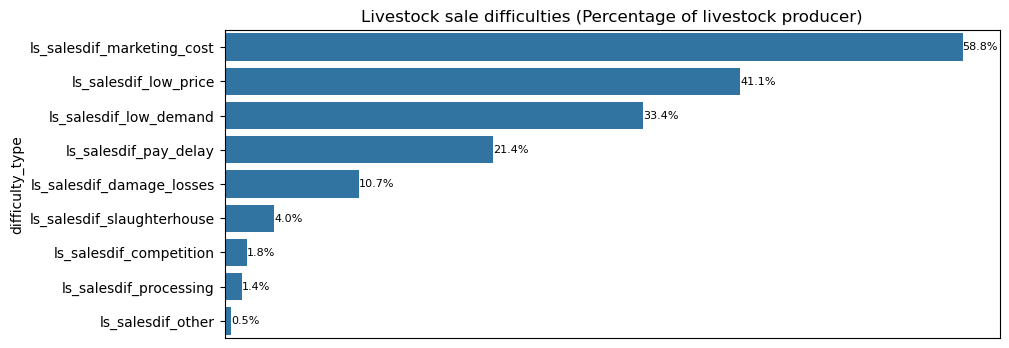

In [139]:
# Livestokc production difficulties
plot_diff_variables(top_ls_salediff, 
                    "Livestock sale difficulties (Percentage of livestock producer)")

In [140]:
# Get all livestock production difficulties cols
all_ls_saledif_col = ls_saledif_col[1:]

# Top crop production difficulty columns
# ls_salediff_df.loc[:, all_ls_saledif_col] = ls_salediff_df[all_ls_saledif_col].fillna(0)


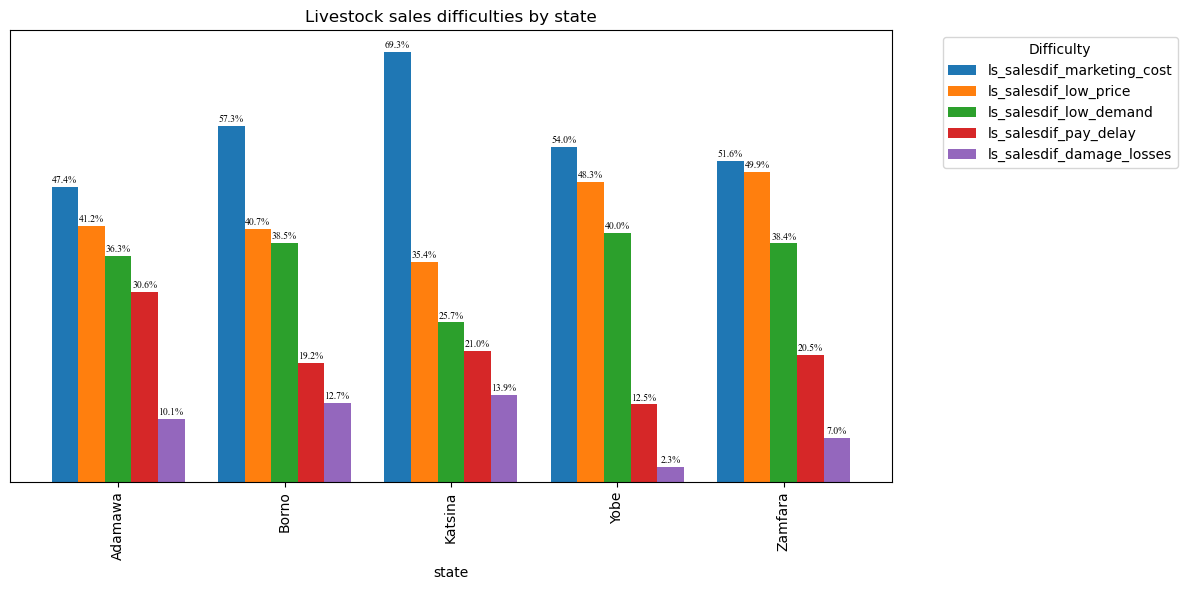

In [141]:
# Top 5 livestock production difficulty
top_ls_salediff = percentage_crp_prod_dif(ls_salediff_df,
                                         start="ls_salesdif_marketing_cost",
                                         end="ls_salesdif_other",
                                          n=5)
# Top livestock sales difficulty columns
top_ls_salediff_col = top_ls_salediff["difficulty_type"].to_list()

# Get all difficulty by state
top_ls_salediff_by_state = all_top_crp_diff_by_state(ls_salediff_df, all_ls_saledif_col)
# Display the result
top_ls_salediff_by_state = top_ls_salediff_by_state[top_ls_salediff_col]


plot_grouped_data(
    top_ls_salediff_by_state,
    kind="bar",
    title="Livestock sales difficulties by state",
    legend_title="Difficulty",
)

In [142]:
# Of the people that have difficulty selling their livestocks, how many
# experienced specific difficulties?


### Changes in herd size

In [143]:
# What percentage of the household reported decrease in the number of livestock
ls_producer_df["ls_num_decreased"].value_counts(normalize=True)

ls_num_decreased
Yes    0.571654
No     0.428346
Name: proportion, dtype: float64

In [144]:
# Median herd decrease
(
    ls_producer_df.query("ls_num_decreased == 'Yes'")
    .groupby("ls_main", observed=True)["ls_num_diff"]
    .median()
)


ls_main
Cattle          -20.0
Equine          -10.0
Goat            -13.0
Poulty          -30.0
Sheep           -12.0
Small Animals   -26.0
Swine           -27.0
Name: ls_num_diff, dtype: float64

In [145]:
# Proportion of household that reports decrease in the number of their livestock
compute_groupby(ls_producer_df, "state", "ls_num_decreased")

ls_num_decreased,No,Yes
state,,
Adamawa,45.745385,54.254615
Borno,45.400721,54.599279
Katsina,36.769445,63.230555
Yobe,44.854947,55.145053
Zamfara,41.783321,58.216679


In [146]:
# Compute the reason for the decrease in livestock size
ls_decrease_reason = percentage_crp_prod_dif(ls_producer_df, 
                       "ls_num_dec_poor_health",
                       "ls_num_dec_consumed",
                       6)
ls_decrease_reason

,difficulty_type,value
0,ls_num_dec_sales_good_price,26.321871
1,ls_num_dec_death,22.018376
2,ls_num_dec_sales_distress,14.848690
3,ls_num_dec_poor_health,13.475711
4,ls_num_dec_escape_stolen,5.665188
5,ls_num_dec_consumed,4.718660


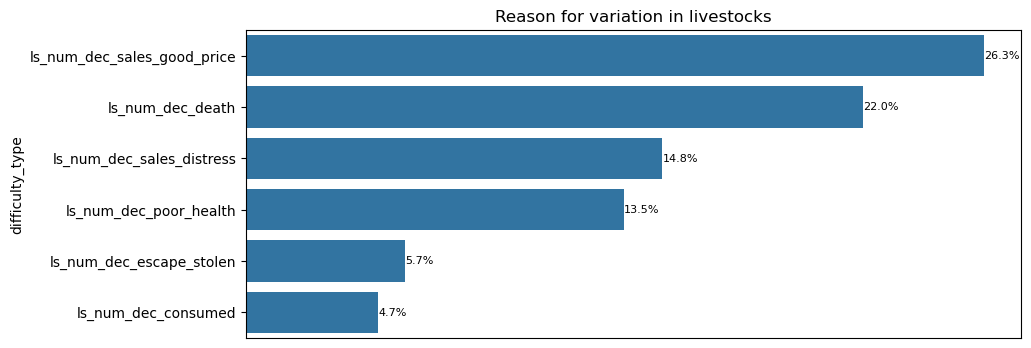

In [147]:
# Plot reason for decrease in livestock
plot_diff_variables(ls_decrease_reason, "Reason for variation in livestocks")

In [148]:
# What is the association between livestock productiondifficulties and 
#  high fuel and food prices, and the presence of insecurity.

In [149]:
# Chi-square Test of Independence

# contigency
ls_diff_vs_shocks_crosstab = pd.crosstab(
    df["ls_proddif"], df.shock_higherfuelprices,margins=False, margins_name="subtotal"
)
ls_diff_vs_shocks_crosstab2 = pd.crosstab(
    df["ls_proddif"], df.shock_higherfoodprices,margins=False, margins_name="subtotal"
)

chi, p1, dof, expected = chi2_contingency(ls_diff_vs_shocks_crosstab)
chi, p2, dof, expected = chi2_contingency(ls_diff_vs_shocks_crosstab2)

print("Association between livestock production vs fuel pricess\n----")
print(p1)
print("\nAssociation between livestock production vs food prices\n----")
print(p2)



Association between livestock production vs fuel pricess
----
5.914308542334755e-10

Association between livestock production vs food prices
----
3.97264955334275e-11


**Observation**



* Households with less livestock than the previous year were more frequent in Yobe (84 percent).
* Cattle, sheep and goats herds decreased, on average:
    - Cattle: -4 (72% of HHs with decrease in herd size)
    - Goats: -5 (69%)
    - Sheep: -5 (60%)
* The main reason for decrease in livestock number is **sold more than usual due to good price** (`ls_num_dec_sales_good_price`)

* About 68 percent of the respondent livestock producers reported a decrease in the number of
livestock compared to last year.
* Livestock producers in Yobe were among those more affected as 84 percent experienced a decrease in the number of livestock.
* Livestock were sold more than usual because of good prices (33 percent) and distress sales (29 percent).
* Livestock production difficulties were associated with high fuel (`shock_higherfuelprices`) and food prices (`shock_higherfoodprices`), and the presence of insecurity as a significant level of 0.05.

## **Needs**
What percentage of the surveyed households reported the need for assistance? And what percentage received assitances

In [150]:
df["need"].value_counts(dropna=False)
need_df = df.dropna(subset=["need"])


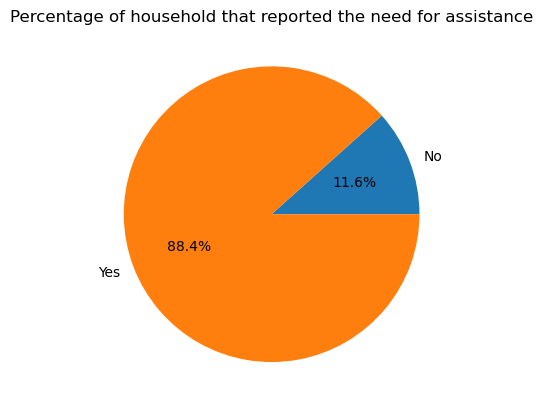

In [151]:
# Calculate the total weight
need_total_weight = need_df["weight_final"].sum()

# calculate total weighted sum of the need
need_weighted_sum = df.groupby("need", observed=True)["weight_final"].sum()

# Calculate the weight percentage
need_weighted_sum = (need_weighted_sum / need_total_weight) * 100

# Rename the index
need_weighted_sum.index  = ["No", "Yes"]

plt.pie(need_weighted_sum, labels=need_weighted_sum.index, autopct="%1.1f%%")
plt.title("Percentage of household that reported the need for assistance")

plt.show()

**Received assistance for need**

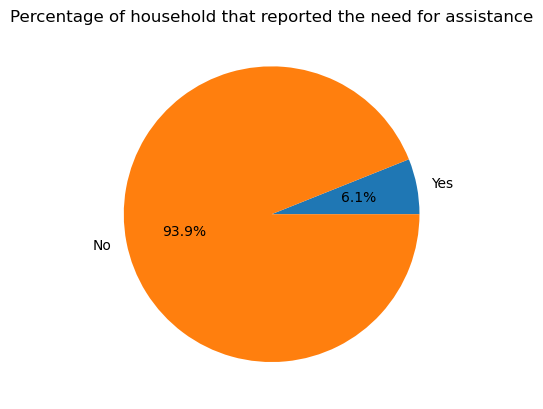

In [152]:
# Received assistance
need_received_col = [col for col in df.columns if col.startswith("need_received")]
# calculate total weighted sum of the need

# calculate total weighted sum of the need
need_received_weighted_sum = df.groupby("need_received_none", observed=True)["weight_final"].sum()

# Calculate the weight percentage
need_received_weighted_sum = (need_received_weighted_sum / need_total_weight) * 100

# Rename the index
need_received_weighted_sum.index  = ["Yes", "No"]

plt.pie(need_received_weighted_sum, labels=need_received_weighted_sum.index, autopct="%1.1f%%")
plt.title("Percentage of household that reported the need for assistance")

plt.show()

**All needs reported by entire surveyed respondents**

In [153]:
need_cols = ["need_crop_infrastructure", "need_cash","need_vouchers_fair",
             "need_food", "need_crop_inputs","need_crop_knowledge", 
             "need_ls_knowledge","need_ls_feed", "need_ls_vet_service", 
             "need_ls_infrastructure", "need_marketing_supp"]

need_cols = [col for col in df.columns if col.startswith("need")]


In [154]:
need_df[need_cols]["need"].value_counts()

need
Yes    1107
No      160
Name: count, dtype: int64

In [155]:

# Top Ten Crop sales  difficulties
all_needs = percentage_crp_prod_dif(
    df, start="need_food", end="need_other", n=13
)
# all_needs

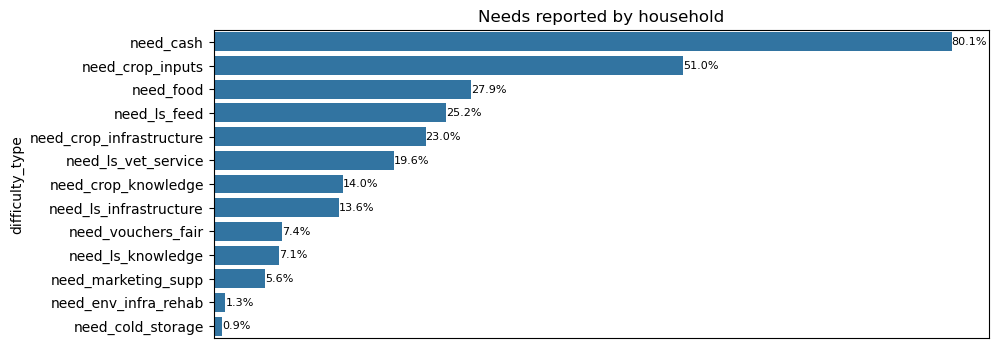

In [156]:
# Plot all the need as reported by household
# The main crop sale difficulties
plot_diff_variables(all_needs, "Needs reported by household")

**Needs by crop producers**

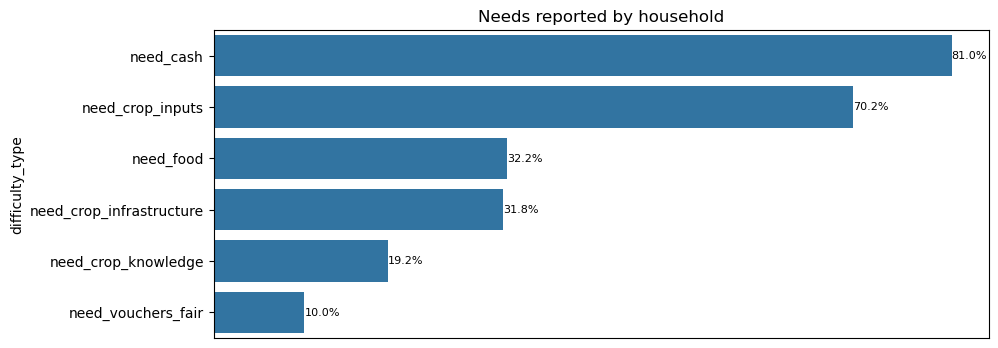

In [157]:
# Top Ten Crop sales  difficulties
crp_producer_needs = percentage_crp_prod_dif(
    crop_producer_df, start="need_food", end="need_crop_knowledge", n=14
)
plot_diff_variables(crp_producer_needs, "Needs reported by household")


In [158]:
crp_producer_needs

,difficulty_type,value
0,need_cash,81.037077
1,need_crop_inputs,70.228009
2,need_food,32.207735
3,need_crop_infrastructure,31.795803
4,need_crop_knowledge,19.180776
5,need_vouchers_fair,9.972266


**Needs by livestock producers**

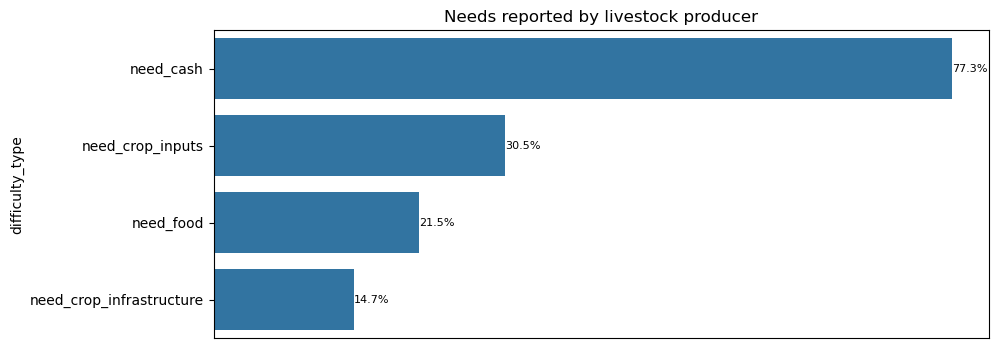

In [159]:
ls_producer_needs = percentage_crp_prod_dif(
    ls_producer_df, start="need_food", end="need_crop_knowledge", n=4
)
plot_diff_variables(ls_producer_needs, "Needs reported by livestock producer")


In [160]:
ls_producer_df[need_cols]["need_ls_vet_service"].value_counts(normalize=True)

need_ls_vet_service
0.0    0.634058
1.0    0.365942
Name: proportion, dtype: float64

In [161]:
need_received_col = [col for col in df.columns if col.startswith("need_received")]
need_received_col


['need_received_food',
 'need_received_cash',
 'need_received_vouchers_fair',
 'need_received_crop_assist',
 'need_received_ls_assist',
 'need_received_fish_assist',
 'need_received_rehabilitation',
 'need_received_sales_support',
 'need_received_other',
 'need_received_none']

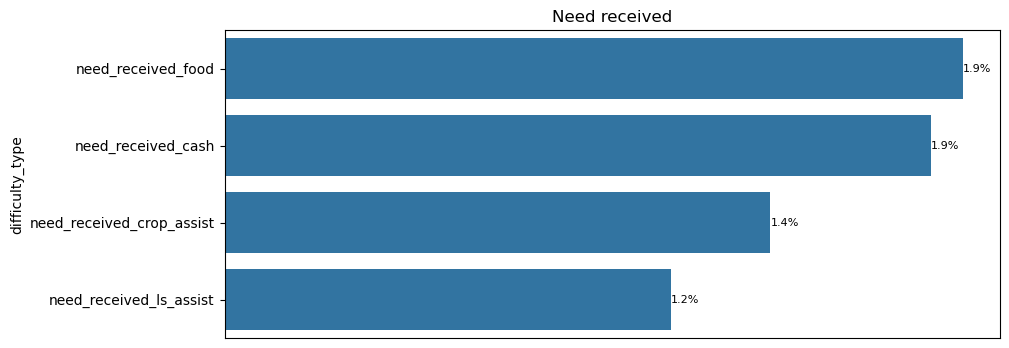

In [162]:
ls_producer_needs = percentage_crp_prod_dif(
    need_df, start="need_received_food", end="need_received_other", n=4
)
plot_diff_variables(ls_producer_needs, "Need received")

**Need by state**
Despite food and cash being requested across all states, some requested specific support.

In [163]:
specific_need_cols = [
    "need_cash",
    "need_food",
    "need_crop_inputs",
    "need_ls_feed",
    "need_crop_infrastructure",
    "need_crop_knowledge",
    "need_ls_knowledge",
    "need_ls_vet_service",
    "need_marketing_supp",
    "need_vouchers_fair"
]

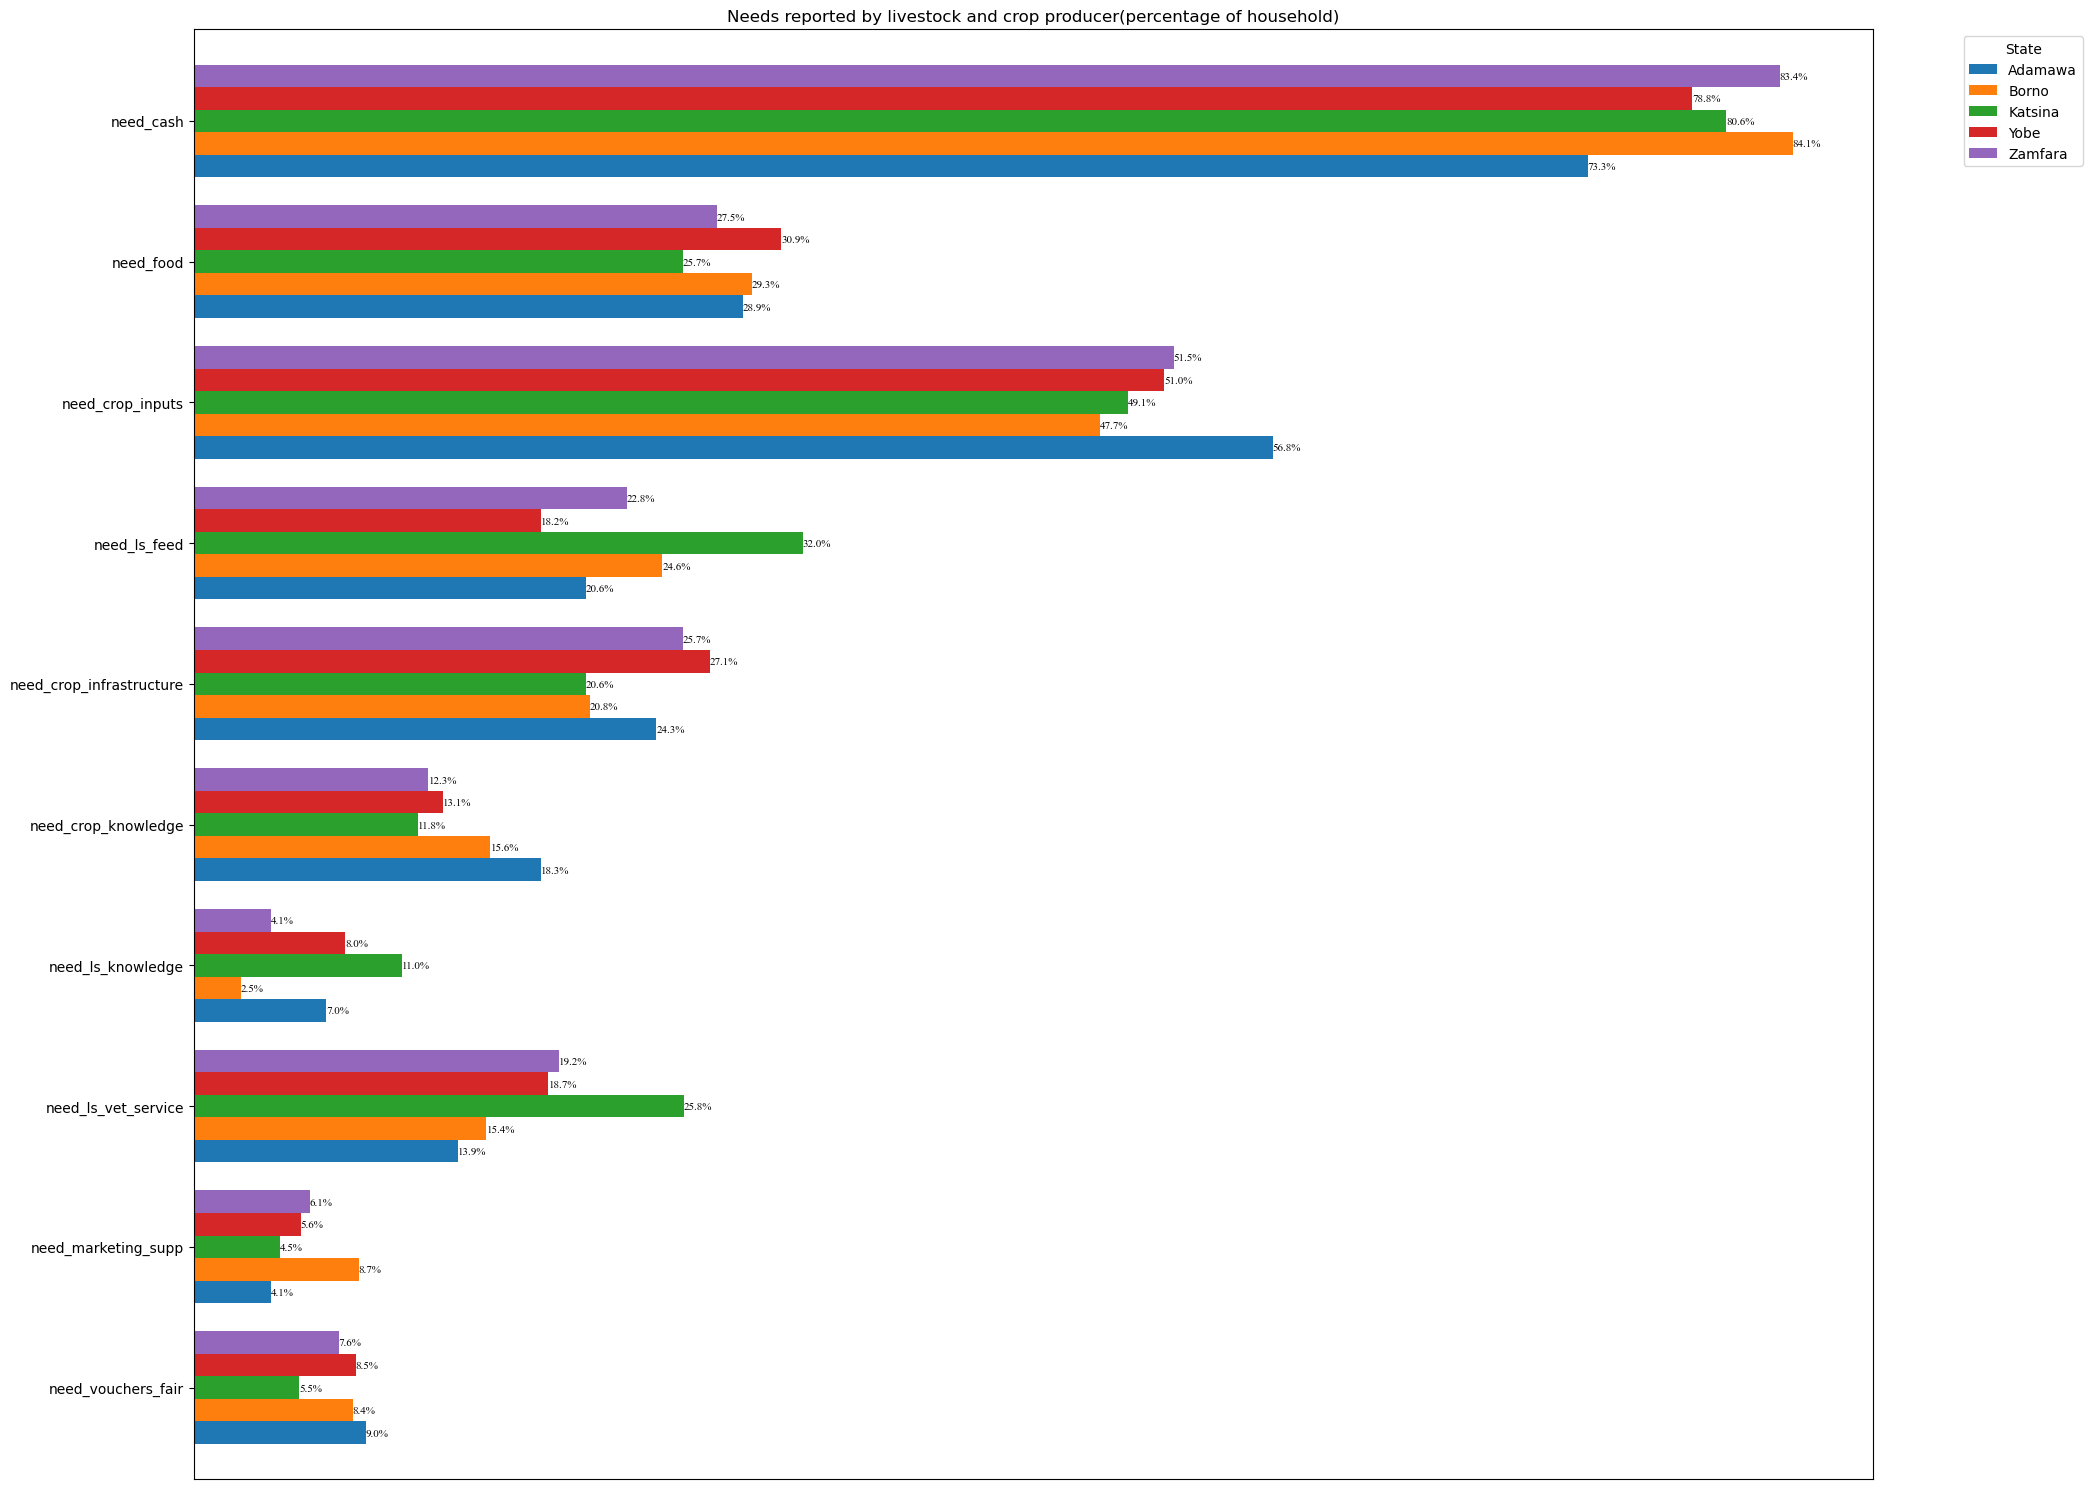

In [164]:

need_recieved = all_top_crp_diff_by_state(df, specific_need_cols[::-1])
plot_grouped_data(
    need_recieved.T,
    kind="barh",
    figsize=(21, 15),
    title="Needs reported by livestock and crop producer(percentage of household)",
    legend_title="State",
)

**Observation**

* About 98.5 percent of the surveyed households reported the need for assistance, but only 9 percent reported having received some form of assistance.
* The received assistance was mainly in the form of cash (5 percent) and food (4 percent).
* Apart from cash and food, crop producers reported the need for crop inputs (96 percent) followed by the need for crop infrastructure (93 percent) and voucher fairs (89 percent).
* Livestock producers reported the need for cash (87 percent), followed by food (81 percent), livestock feed (50 percent) andveterinary services (37 percent).

**More Observation**
* Despite food and cash being requested across all states, some requested specific support. In
Adamawa, respondents identified the need for livestock feed;
* In Borno, respondents requested crop infrastructure, voucher fairs, veterinary services and veterinary feed;
* In Katsina, respondents requested livestock feed and veterinary services; and
* In Yobe, respondents identified the need for crop knowledge, voucher fairs, livestock feed and crop infrastructure

## **Create New Features**

In [165]:
# Household that experience either crop or livestock production difficulty
df["any_proddiff"] = np.where(
    (df["crp_proddif"] == "Yes") | (df["ls_proddif"] == "Yes"), "Yes", "No"
)

In [166]:
# Household that experience either crop or livestock sale difficulty
df["any_salediff"] = np.where((df["crp_salesdif"] == "Yes") | \
                                   (df["ls_salesdif"] == "Yes"), "Yes", "No")

### Create a new column `any_dif`

In [167]:


# Use NumPy to check if all values in each row are 'Yes'
any_dif = np.any(df[["any_proddiff", "any_salediff"]].values == "Yes", axis=1)

# Assign the result to the new column 'any_dif' using .loc
df.loc[:, "any_dif"] = np.where(any_dif, 1.0, 0.0)

### # Save data for modelling

In [168]:
# Save data for modelling
df.to_csv("../../data/diem_hdds_round_4.csv", index=False)

## Coping Strategy

In [169]:
df.filter(like="income")

,income_main,income_main_amount,income_sec_amount,income_main_comp,income_sec,income_third,tot_income,income_main_cat,income_more_than_one,income_comp_clean
0,3.0,200000.0,NaN,Same,19.0,19.0,200000.0,Agricultural employment,No,Same
1,4.0,390000.0,223000.0,More,3.0,2.0,613000.0,Agricultural employment,Yes,Increase
2,4.0,500000.0,200000.0,Less,1.0,19.0,700000.0,Agricultural employment,Yes,Decrease
3,1.0,187000.0,74900.0,More,4.0,19.0,261900.0,Agricultural employment,Yes,Increase
4,4.0,230000.0,NaN,Same,19.0,19.0,230000.0,Agricultural employment,No,Same
...,...,...,...,...,...,...,...,...,...,...
1413,2.0,120000.0,NaN,Less,19.0,19.0,120000.0,Agricultural employment,No,Decrease
1414,11.0,200000.0,NaN,More,19.0,19.0,200000.0,Non Agricultural employment,No,Increase
1415,4.0,200000.0,NaN,Less,19.0,19.0,200000.0,Agricultural employment,No,Decrease
1416,1.0,40000.0,NaN,A lot less,19.0,19.0,40000.0,Agricultural employment,No,Decrease


In [170]:
rcsi_cols = [col for col in df.columns if col.startswith("rcsi_")]
rcsi_col= rcsi_cols[:-2]+["weight_final", "state"]
df_rsci = df[rcsi_col]

# #rename column name
new_col_name = ["rCSILessQlty", "rCSIBorrow", "rCSIMealNb", "rCSIMealSize", "rCSIMealAdult"]
df_rsci.columns.values[0:5]= new_col_name

df_rsci[df_rsci.iloc[:, 0:5].columns] = df_rsci.iloc[:, 0:5].apply(pd.to_numeric)

# df_rsci[rcsi_variables[:-2]] = df_rsci.loc[:, df_rsci.columns[:-2]].astype(int)
df_rsci.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1414 entries, 0 to 1417
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   rCSILessQlty   1414 non-null   float64 
 1   rCSIBorrow     1414 non-null   float64 
 2   rCSIMealNb     1414 non-null   float64 
 3   rCSIMealSize   1414 non-null   float64 
 4   rCSIMealAdult  1414 non-null   float64 
 5   weight_final   1414 non-null   float64 
 6   state          1414 non-null   category
dtypes: category(1), float64(6)
memory usage: 78.9 KB


/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_6039/3333097942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rsci[df_rsci.iloc[:, 0:5].columns] = df_rsci.iloc[:, 0:5].apply(pd.to_numeric)


In [171]:
df_rsci.loc[:, df_rsci.columns[:-2]] = df_rsci.loc[:, df_rsci.columns[:-2]].map(lambda x: 1 if x > 0 else 0)

df_rsci.head()

,rCSILessQlty,rCSIBorrow,rCSIMealNb,rCSIMealSize,rCSIMealAdult,weight_final,state
0,0.0,0.0,0.0,0.0,0.0,0.640673,Yobe
1,0.0,0.0,0.0,0.0,0.0,0.802971,Zamfara
2,1.0,0.0,0.0,1.0,0.0,0.845520,Adamawa
3,0.0,0.0,0.0,0.0,0.0,0.802971,Zamfara
4,0.0,1.0,0.0,1.0,0.0,1.286373,Borno


In [172]:
def all_top_crp_diff_by_state(df, var, subset: list):
    crp_prod = df.dropna(subset=subset)
    weighted_crp_diff = (
        crp_prod[subset].astype(float).multiply(crp_prod["weight_final"], axis=0)
    )
    weighted_df = crp_prod[[var, "weight_final"]].join(weighted_crp_diff)

    # Group by state and sum the weighted counts and weights
    grouped = weighted_df.groupby(var, observed=True).sum()

    # Calculate the percentage for each shock
    for col in subset:
        grouped[col] = (grouped[col] / grouped["weight_final"]) * 100
        # Keep only the percentage columns
    percentage_columns = [col for col in subset]
    all_shocks_by_state = grouped[percentage_columns]
    return all_shocks_by_state

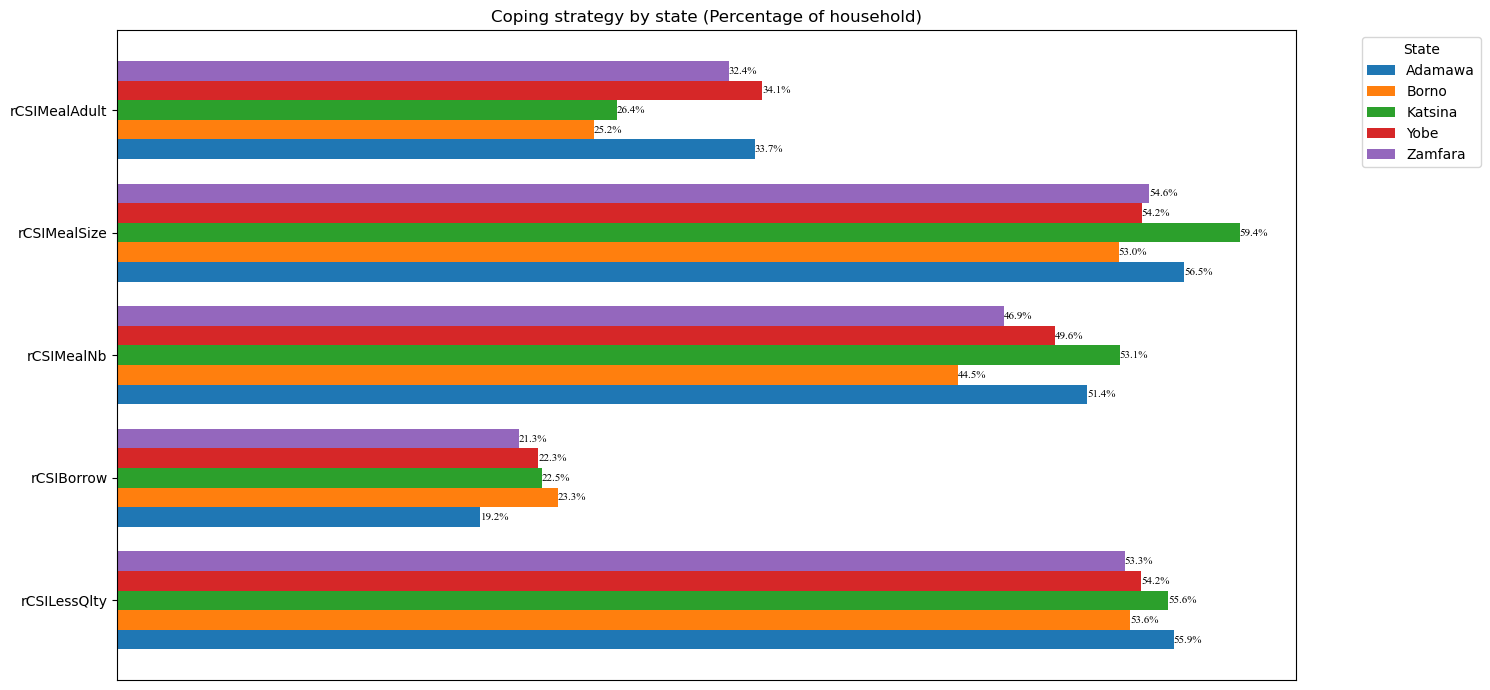

In [173]:
rsci = all_top_crp_diff_by_state(df_rsci, "state", df_rsci.columns[:-2].to_list())
plot_grouped_data(
    rsci.T,
    kind="barh",
    figsize=(15, 7),
    title="Coping strategy by state (Percentage of household)",
    legend_title="State",
)

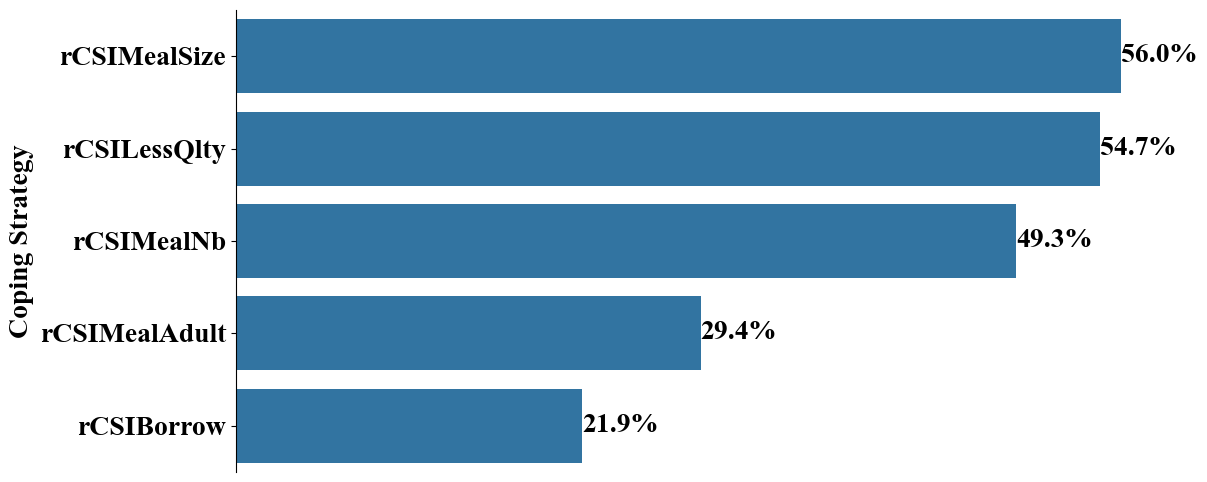

In [174]:
rsci = percentage_crp_prod_dif(
    df_rsci, start="rCSILessQlty", end="rCSIMealAdult", n=5
)

def plot_diff_variables(crp_proddiff_df: pd.DataFrame, title: str) -> None:
    # Plot the shocks
    font = {'family' : 'Times New Roman',
          'weight' : 'bold',
           'size': 20}
    
    rc('font', **font) 
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        crp_proddiff_df,
        x="value",
        y="difficulty_type",

    )

    # Add percentage labels to the bars
    ax.bar_label(ax.containers[0], fontsize=20, fmt="%1.1f%%")


    
    

    # Remove top, right, and bottom borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Remove x-axis ticks and lables
    ax.set_ylabel("Coping Strategy",fontdict=font )
    
    ax.xaxis.set_ticks([])
    ax.set_xlabel("")
    ax.set_title(title)

    plt.show()


plot_diff_variables(rsci, "")

In [175]:
df.shape

(1414, 226)